# Libraries

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Scikit-learn Packages
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import KFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# Tensor Flow Packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam, RMSprop

from lime import lime_image
from skimage.segmentation import mark_boundaries

/Users/ryan/Documents/GitHub/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Preprocessing

## Internal Dataset

In [3]:
# Set parameters
IMG_SIZE = 64  # Target size for resizing images
DATASET_DIR = Path.home() / 'Documents'/ 'NUS' / 'Y2S1'/'IT1244' / 'IT1244_Team 9_Project'  / 'Code_Folder'/ 'images'  # Path to dataset

# To load and resize images
def load_images(dataset_dir, img_size):
    images = []
    labels = []
    for filename in os.listdir(dataset_dir):
        if filename.endswith('.png'):
            img_path = os.path.join(dataset_dir, filename)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (img_size, img_size))  # Resize to the target size
            label = int(filename.split('_')[0])  # Extract class label from filename
            images.append(img)
            labels.append(label)
    return np.array(images), np.array(labels)

# Load, resize and normalise the dataset
X, y = load_images(DATASET_DIR, IMG_SIZE)
X = X / 255.0  # Normalize pixel values to [0,1]

## External Testset

In [4]:
# Load, resize and normalise external test set
DATASET_DIR2 = Path.home()/ 'Documents'/ 'NUS' / 'Y2S1'/'IT1244' / 'IT1244_Team 9_Project'  / 'Code_Folder'/ 'test_set'
X_new, y_new = load_images(DATASET_DIR2, IMG_SIZE)
X_new = X_new / 255.0 

# Train Test Split & Flattening Dataset

In [5]:
# Split into train (80%) and test set (20%)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) 

# Split into train (70%) and validation (10%)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, random_state=42, stratify=y_train_val) 

## Flattening dataset

In [6]:
# Flatten the dataset
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Flatten the new dataset
X_new_flat = X_new.reshape(X_new.shape[0], -1)

# Visualising Class Distribution

In [7]:
# Class distribution for the original dataset
print("Original dataset class distribution:")
print(pd.Series(y).value_counts())

# Class distribution for the train dataset
print("Original dataset class distribution:")
print(pd.Series(y_train).value_counts())

# Class distribution for the validation dataset
print("Original dataset class distribution:")
print(pd.Series(y_val).value_counts())

# Class distribution for the test dataset
print("y_test class distribution:")
print(pd.Series(y_test).value_counts())

Original dataset class distribution:
0     514
1     500
2     344
3     268
4     260
5     244
6     220
7     218
8     214
9     202
10    202
11    198
12    184
13    156
14    150
16    140
15    140
17    132
18    130
19    128
20    126
21    118
22    108
Name: count, dtype: int64
Original dataset class distribution:
0     370
1     360
2     247
3     193
4     187
5     175
6     158
7     157
8     154
9     146
10    146
11    142
12    132
13    112
14    108
16    101
15    101
17     95
18     94
19     92
20     91
21     85
22     78
Name: count, dtype: int64
Original dataset class distribution:
0     41
1     40
2     28
3     21
4     21
5     20
6     18
8     17
7     17
10    16
11    16
9     16
12    15
13    13
14    12
15    11
16    11
17    11
18    10
19    10
20    10
22     9
21     9
Name: count, dtype: int64
y_test class distribution:
0     103
1     100
2      69
3      54
4      52
5      49
7      44
6      44
8      43
10     40
11     40
9      

# CNN model

## Baseline CNN

In [8]:
# To build baseline CNN model
def build_cnn_model2(input_shape, num_classes):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    return model

## K-fold validation - Baseline CNN

In [9]:
# Set up K-Fold Cross Validation
k = 5  # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Manually split X_train and y_train into k folds and store results
folds = []
for train_index, val_index in kf.split(X_train_val):
    X_train_fold, X_val_fold = X_train_val[train_index], X_train_val[val_index]
    y_train_fold, y_val_fold = y_train_val[train_index], y_train_val[val_index]
    folds.append((X_train_fold, X_val_fold, y_train_fold, y_val_fold))
    
# Initialize lists to store results for each fold
val_accuracies = []
val_losses = []

# Train model on each fold and evaluate validation accuracy and loss
for fold_number in range(k):
    X_train_fold, X_val_fold, y_train_fold, y_val_fold = folds[fold_number]

    # Build and compile the CNN model
    cnn_model2 = build_cnn_model2(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=len(np.unique(y)))
    cnn_model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Train model on fold data
    history = cnn_model2.fit(X_train_fold, y_train_fold, batch_size=32,epochs=10, validation_data=(X_val_fold, y_val_fold))

    # Evaluate fold accuracy and loss
    val_loss, val_accuracy = cnn_model2.evaluate(X_val_fold, y_val_fold)
    val_accuracies.append(val_accuracy)
    val_losses.append(val_loss)
    print(f'Fold {fold_number} - Validation Accuracy: {val_accuracy:.4f}, Validation Loss: {val_loss:.4f}')

# Calculate average validation accuracy and loss across folds
avg_val_accuracy = np.mean(val_accuracies)
avg_val_loss = np.mean(val_losses)
print(f'Average Validation Accuracy: {avg_val_accuracy:.4f}, Average Validation Loss: {avg_val_loss:.4f}')


Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.3445 - loss: 2.3004 - val_accuracy: 0.8814 - val_loss: 0.4206
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.9152 - loss: 0.2907 - val_accuracy: 0.9554 - val_loss: 0.1635
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.9715 - loss: 0.0896 - val_accuracy: 0.9694 - val_loss: 0.1015
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9864 - loss: 0.0530 - val_accuracy: 0.9796 - val_loss: 0.0945
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.9942 - loss: 0.0283 - val_accuracy: 0.9796 - val_loss: 0.0784
Epoch 6/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 1.0000 - loss: 0.0054 - val_accuracy: 0.9732 - val_loss: 0.1024
Epoch 7/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.9987 - loss: 0.0145 - val_accuracy: 0.9860 - val_loss: 0.0656
Epoch 8/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.9999 - loss: 0.0026 - val_accuracy: 0.9809 - v

In [10]:
cnn_model2 = build_cnn_model2(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=len(np.unique(y)))
cnn_model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history2 = cnn_model2.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.3759 - loss: 2.1562 - val_accuracy: 0.8444 - val_loss: 0.4640
Epoch 2/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.9184 - loss: 0.2760 - val_accuracy: 0.9439 - val_loss: 0.1763
Epoch 3/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.9754 - loss: 0.0841 - val_accuracy: 0.9694 - val_loss: 0.1081
Epoch 4/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9884 - loss: 0.0390 - val_accuracy: 0.9898 - val_loss: 0.0374
Epoch 5/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.9926 - loss: 0.0190 - val_accuracy: 0.9872 - val_loss: 0.0345
Epoch 6/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.9999 - loss: 0.0059 - val_accuracy: 0.9949 - val_loss: 0.0300
Epoch 7/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.9983 - loss: 0.0097 - val_accuracy: 0.9949 - val_loss: 0.0270
Epoch 8/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.9994 - loss: 0.0043 - val_accu

## External Dataset - Baseline CNN

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


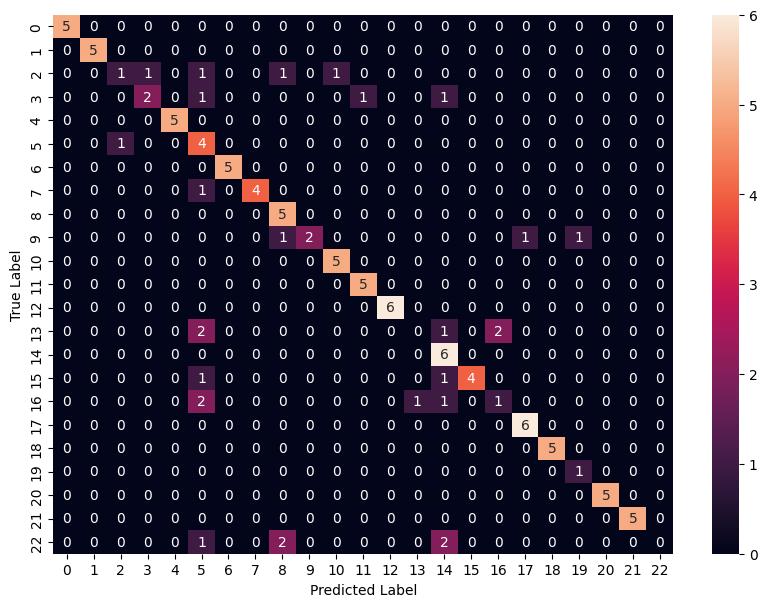

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       0.50      0.20      0.29         5
           3       0.67      0.40      0.50         5
           4       1.00      1.00      1.00         5
           5       0.31      0.80      0.44         5
           6       1.00      1.00      1.00         5
           7       1.00      0.80      0.89         5
           8       0.56      1.00      0.71         5
           9       1.00      0.40      0.57         5
          10       0.83      1.00      0.91         5
          11       0.83      1.00      0.91         5
          12       1.00      1.00      1.00         6
          13       0.00      0.00      0.00         5
          14       0.50      1.00      0.67         6
          15       1.00      0.67      0.80         6
          16       0.33      0.20      0.25         5
          17       0.86    

/Users/ryan/Documents/GitHub/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ryan/Documents/GitHub/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ryan/Documents/GitHub/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

In [11]:
# Predict the External set
y_pred2 = cnn_model2.predict(X_new)
y_pred_classes2 = np.argmax(y_pred2, axis=1)

# Confusion matrix
conf_matrix2 = confusion_matrix(y_new, y_pred_classes2)

# Visualize confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix2, annot=True, fmt="d")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Classification report
print(classification_report(y_new, y_pred_classes2))

## Fine-tuned CNN

In [12]:
# Comprehensive CNN model
def build_cnn_model(input_shape, num_classes, optimizer='adam', dropout_rate=0.5):
    model = Sequential([
        Input(shape=input_shape),
        Conv2D(32, (3, 3), activation='relu', name='conv1'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu', name='conv2'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, (3, 3), activation='relu', name='conv3'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(dropout_rate),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

## Grid Search

In [13]:
# Hyperparameter grid for tuning
param_grid = {
    'batch_size': [32, 64],
    'epochs': [10, 20],
    'optimizer': ['adam', 'rmsprop'],
    'dropout_rate': [0.3, 0.5]
}

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

# Perform manual grid search to find top performing configurations
top_results = []
for batch_size in param_grid['batch_size']:
    for epochs in param_grid['epochs']:
        for optimizer_name in param_grid['optimizer']:
            for dropout_rate in param_grid['dropout_rate']:
               # Choose optimizer based on the parameter grid
                optimizer = Adam() if optimizer_name == 'adam' else RMSprop()
                
                # Build and compile model
                model = build_cnn_model(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=len(np.unique(y)), optimizer=optimizer, dropout_rate=dropout_rate)
                
               # Train model and track validation accuracy for last epoch
                history = model.fit(X_train, y_train,validation_data=(X_val, y_val),batch_size=batch_size,epochs=epochs,class_weight=class_weight_dict,verbose=0)
                val_accuracy = history.history['val_accuracy'][-1]
                
                # Record and rank top 3 results
                current_result = {'batch_size': batch_size,'epochs': epochs,'optimizer': optimizer_name,'dropout_rate': dropout_rate,'val_accuracy': val_accuracy}
                top_results.append(current_result)
                top_results = sorted(top_results, key=lambda x: x['val_accuracy'], reverse=True)[:3]
                print(f"Params: batch_size={batch_size}, epochs={epochs}, optimizer={optimizer_name}, "
                      f"dropout_rate={dropout_rate} - Validation Accuracy: {val_accuracy:.4f}")

# Output the top 3 parameters and accuracies
print("\nTop 3 validation results:")
for i, result in enumerate(top_results, 1):
    print(f"Rank {i}: Validation Accuracy: {result['val_accuracy']:.4f} with Params: "
          f"batch_size={result['batch_size']}, epochs={result['epochs']}, "
          f"optimizer={result['optimizer']}, dropout_rate={result['dropout_rate']}")


Params: batch_size=32, epochs=10, optimizer=adam, dropout_rate=0.3 - Validation Accuracy: 0.9949
Params: batch_size=32, epochs=10, optimizer=adam, dropout_rate=0.5 - Validation Accuracy: 0.9923
Params: batch_size=32, epochs=10, optimizer=rmsprop, dropout_rate=0.3 - Validation Accuracy: 0.9949
Params: batch_size=32, epochs=10, optimizer=rmsprop, dropout_rate=0.5 - Validation Accuracy: 0.9847
Params: batch_size=32, epochs=20, optimizer=adam, dropout_rate=0.3 - Validation Accuracy: 0.9949
Params: batch_size=32, epochs=20, optimizer=adam, dropout_rate=0.5 - Validation Accuracy: 0.9923
Params: batch_size=32, epochs=20, optimizer=rmsprop, dropout_rate=0.3 - Validation Accuracy: 1.0000
Params: batch_size=32, epochs=20, optimizer=rmsprop, dropout_rate=0.5 - Validation Accuracy: 0.9949
Params: batch_size=64, epochs=10, optimizer=adam, dropout_rate=0.3 - Validation Accuracy: 0.9949
Params: batch_size=64, epochs=10, optimizer=adam, dropout_rate=0.5 - Validation Accuracy: 0.9923
Params: batch_size

## Data Augmentation 

In [14]:
def add_rain(image):
    image = image.astype(np.uint8)
    rain_layer = np.zeros_like(image, dtype=np.uint8)
    num_drops = 1000
    
    for _ in range(num_drops):
        x, y = np.random.randint(0, rain_layer.shape[1]), np.random.randint(0, rain_layer.shape[0])
        length = np.random.randint(15, 25)
        cv2.line(rain_layer, (x, y), (x, y + length), (200, 200, 200), 1)
    
    rain_layer = cv2.blur(rain_layer, (3, 3))
    return cv2.addWeighted(image, 0.7, rain_layer, 0.3, 0)

def add_fog(image):
    image = image.astype(np.uint8)
    fog_layer = np.zeros_like(image, dtype=np.uint8)
    fog_intensity = np.random.uniform(0.3, 0.6)
    
    for i in range(image.shape[0]):
        overlay_intensity = int(fog_intensity * 255 * (i / image.shape[0]))
        fog_layer[i, :, :] = overlay_intensity
    
    fog_layer = cv2.blur(fog_layer, (15, 15))
    return cv2.addWeighted(image, 0.8, fog_layer, 0.2, 0)

def add_snow(image):
    image = image.astype(np.uint8)
    snow_layer = np.zeros_like(image, dtype=np.uint8)
    num_flakes = 1000
    
    for _ in range(num_flakes):
        x, y = np.random.randint(0, snow_layer.shape[1]), np.random.randint(0, snow_layer.shape[0])
        cv2.circle(snow_layer, (x, y), np.random.randint(1, 3), (255, 255, 255), -1)
    
    snow_layer = cv2.blur(snow_layer, (3, 3))
    return cv2.addWeighted(image, 0.8, snow_layer, 0.2, 0)

def add_sunshine(image):
    image = image.astype(np.uint8)
    sunshine_layer = np.zeros_like(image, dtype=np.uint8)
    center_x, center_y = np.random.randint(0, image.shape[1]), np.random.randint(0, image.shape[0])
    radius = np.random.randint(image.shape[0] // 2, image.shape[0])
    intensity = np.random.uniform(0.4, 0.6)
    
    cv2.circle(sunshine_layer, (center_x, center_y), radius, (255, 255, 100), -1)
    sunshine_layer = cv2.GaussianBlur(sunshine_layer, (91, 91), 0)
    
    return cv2.addWeighted(image, 0.8, sunshine_layer, intensity, 0)


def apply_weather_effects(image):
    # Choose one weather effect randomly
    effect_functions = [add_rain, add_fog, add_snow, add_sunshine]
    chosen_effect = np.random.choice(effect_functions)
    
    # Apply the chosen effect
    augmented_image = chosen_effect(image)
    
    return augmented_image

# Data augmentation to prevent overfitting
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest',
    preprocessing_function=apply_weather_effects
)


## K-fold Validation - Fine-tuned CNN model

In [15]:
# Set up K-Fold Cross Validation
k = 5  # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Manually split X_train and y_train into k folds and store results
folds = []
for train_index, val_index in kf.split(X_train_val):
    X_train_fold, X_val_fold = X_train_val[train_index], X_train_val[val_index]
    y_train_fold, y_val_fold = y_train_val[train_index], y_train_val[val_index]
    folds.append((X_train_fold, X_val_fold, y_train_fold, y_val_fold))
    
# Initialize lists to store results for each fold
val_accuracies = []
val_losses = []

# Train model on each fold and evaluate validation accuracy and loss
for fold_number in range(k):
    X_train_fold, X_val_fold, y_train_fold, y_val_fold = folds[fold_number]

    # Build and compile the CNN model
    cnn_model = build_cnn_model(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=len(np.unique(y)), optimizer='adam', dropout_rate=0.3)
    
    datagen.fit(X_train_fold)
    
    # Train model on fold data
    history = cnn_model.fit(X_train_fold, y_train_fold, batch_size=32,epochs=10,validation_data=(X_val_fold, y_val_fold))
    
     # Evaluate fold accuracy and loss
    val_loss, val_accuracy = cnn_model.evaluate(X_val_fold, y_val_fold)
    val_accuracies.append(val_accuracy)
    val_losses.append(val_loss)
    print(f'Fold {fold_number} - Validation Accuracy: {val_accuracy:.4f}, Validation Loss: {val_loss:.4f}')

# Calculate average validation accuracy and loss across folds
avg_val_accuracy = np.mean(val_accuracies)
avg_val_loss = np.mean(val_losses)
print(f'Average Validation Accuracy: {avg_val_accuracy:.4f}, Average Validation Loss: {avg_val_loss:.4f}')


Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.1691 - loss: 2.8136 - val_accuracy: 0.5982 - val_loss: 1.3585
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.6222 - loss: 1.1956 - val_accuracy: 0.9171 - val_loss: 0.3335
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.8481 - loss: 0.4641 - val_accuracy: 0.9592 - val_loss: 0.1629
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.9389 - loss: 0.2022 - val_accuracy: 0.9732 - val_loss: 0.1014
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.9669 - loss: 0.1182 - val_accuracy: 0.9732 - val_loss: 0.0818
Epoch 6/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9737 - loss: 0.0934 - val_accuracy: 0.9898 - val_loss: 0.0545
Epoch 7/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.9747 - loss: 0.0765 - val_accuracy: 0.9872 - val_loss: 0.0477
Epoch 8/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9866 - loss: 0.0468 - val_accuracy: 0.9923 - v

## Final Model

In [16]:
# Initialise the fine-tuned CNN model
cnn_model = build_cnn_model(input_shape = (IMG_SIZE, IMG_SIZE, 3), num_classes = len(np.unique(y)), optimizer='adam', dropout_rate=0.3)

# Apply data augmentation on the training data
datagen.fit(X_train)

# Compute class weights to overcome imbalanced dataset
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

# Train the CNN model with training data, and validate on validation data
history = cnn_model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val), class_weight=class_weight_dict)

Epoch 1/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.1308 - loss: 2.8570 - val_accuracy: 0.6990 - val_loss: 1.0026
Epoch 2/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.6573 - loss: 1.0910 - val_accuracy: 0.8622 - val_loss: 0.3997
Epoch 3/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8285 - loss: 0.4968 - val_accuracy: 0.9490 - val_loss: 0.1665
Epoch 4/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.9343 - loss: 0.2296 - val_accuracy: 0.9617 - val_loss: 0.1047
Epoch 5/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.9491 - loss: 0.1481 - val_accuracy: 0.9821 - val_loss: 0.0759
Epoch 6/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.9648 - loss: 0.1117 - val_accuracy: 0.9872 - val_loss: 0.0477
Epoch 7/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.9651 - loss: 0.1101 - val_accuracy: 0.9898 - val_loss: 0.0405
Epoch 8/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.9725 - loss: 0.0691 - val_accu

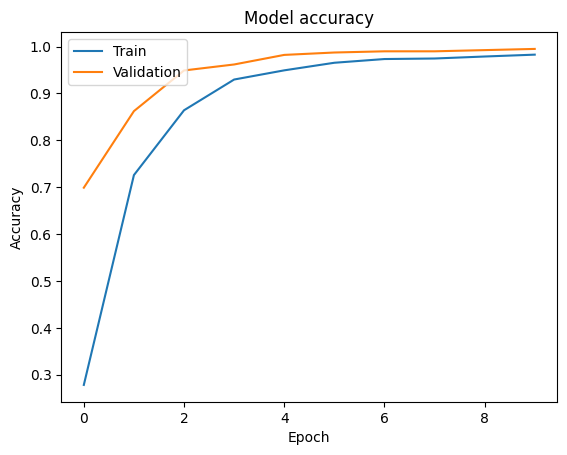

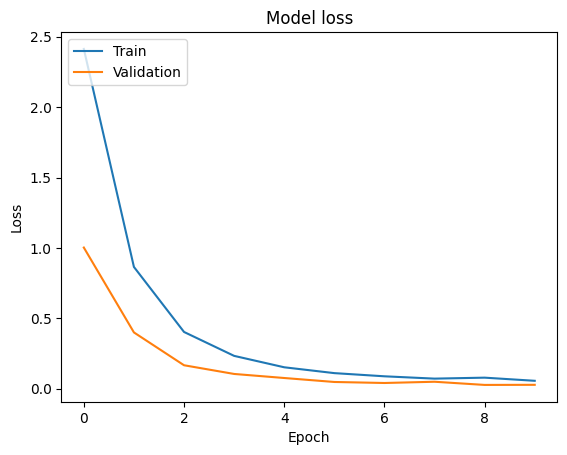

In [17]:
# Plot training & validation accuracy values over epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training and validation loss over epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Internal Dataset Result - Final Model

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


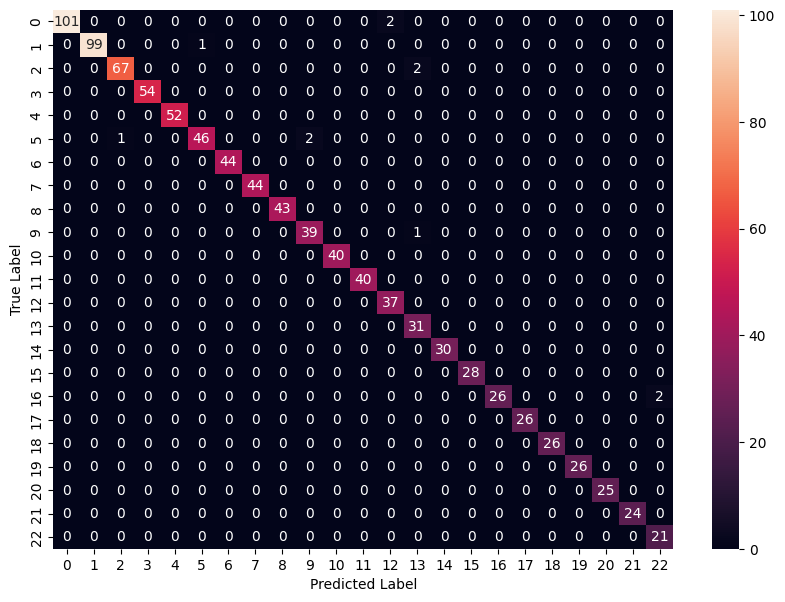

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       103
           1       1.00      0.99      0.99       100
           2       0.99      0.97      0.98        69
           3       1.00      1.00      1.00        54
           4       1.00      1.00      1.00        52
           5       0.98      0.94      0.96        49
           6       1.00      1.00      1.00        44
           7       1.00      1.00      1.00        44
           8       1.00      1.00      1.00        43
           9       0.95      0.97      0.96        40
          10       1.00      1.00      1.00        40
          11       1.00      1.00      1.00        40
          12       0.95      1.00      0.97        37
          13       0.91      1.00      0.95        31
          14       1.00      1.00      1.00        30
          15       1.00      1.00      1.00        28
          16       1.00      0.93      0.96        28
          17       1.00    

In [18]:
# Predict the test set
y_pred = cnn_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1) # Convert prediction probabilities to class labels

# Create a confusion matrix to evaluate the predictions on the test set
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Visualize confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Classification report
print(classification_report(y_test, y_pred_classes))

## External Dataset Result - Final Model

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


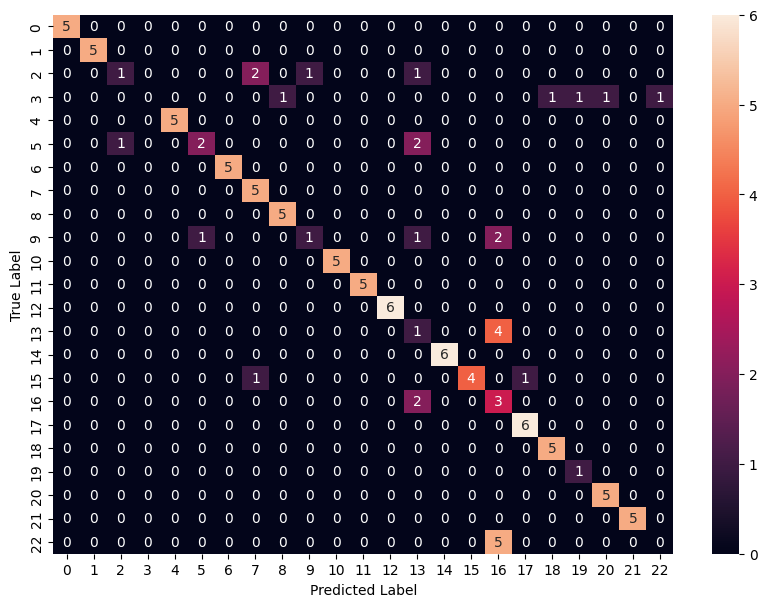

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       0.50      0.20      0.29         5
           3       0.00      0.00      0.00         5
           4       1.00      1.00      1.00         5
           5       0.67      0.40      0.50         5
           6       1.00      1.00      1.00         5
           7       0.62      1.00      0.77         5
           8       0.83      1.00      0.91         5
           9       0.50      0.20      0.29         5
          10       1.00      1.00      1.00         5
          11       1.00      1.00      1.00         5
          12       1.00      1.00      1.00         6
          13       0.14      0.20      0.17         5
          14       1.00      1.00      1.00         6
          15       1.00      0.67      0.80         6
          16       0.21      0.60      0.32         5
          17       0.86    

/Users/ryan/Documents/GitHub/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ryan/Documents/GitHub/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ryan/Documents/GitHub/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

In [19]:
# Predict the external set
y_pred = cnn_model.predict(X_new)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion matrix
conf_matrix = confusion_matrix(y_new, y_pred_classes)

# Visualize confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Classification report
print(classification_report(y_new, y_pred_classes))

# Visualising Model Prediction

Correct Predictions:


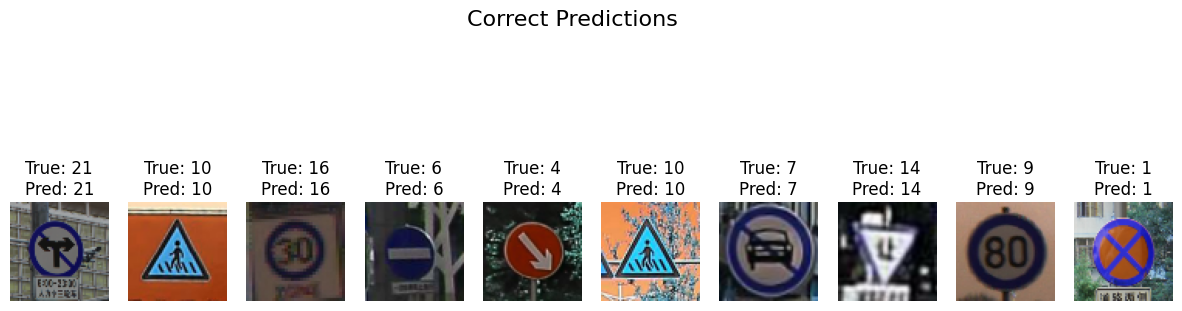

Incorrect Predictions:


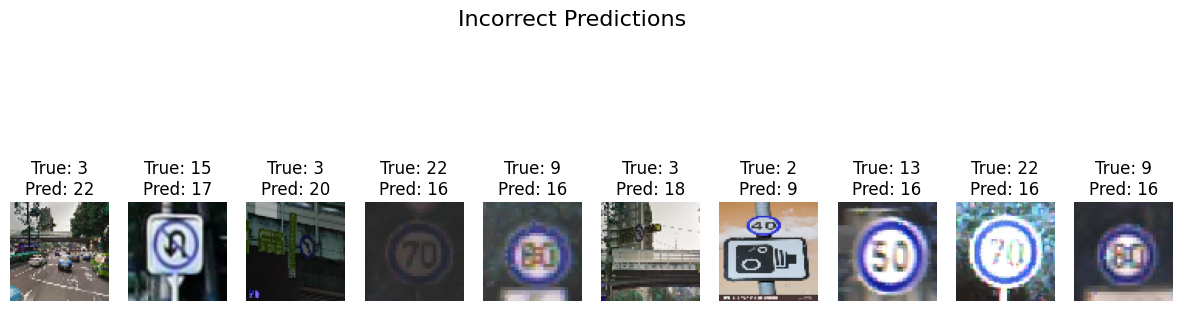

In [20]:
correct_indices = np.where(y_new == y_pred_classes)[0]  # Indices where predictions are correct
incorrect_indices = np.where(y_new != y_pred_classes)[0]  # Indices where predictions are wrong

# Function to display images side by side
def display_images_side_by_side(images, true_labels, predicted_labels, title):
    plt.figure(figsize=(15, 5))  # Adjust the figure size as needed
    for i in range(len(images)):
        plt.subplot(1, len(images), i + 1)  # 1 row, len(images) columns
        plt.imshow(images[i])
        plt.title(f"True: {true_labels[i]}\nPred: {predicted_labels[i]}")
        plt.axis('off')  # Remove axis
    plt.suptitle(title, fontsize=16)
    plt.show()

# Display Correct Predictions
print("Correct Predictions:")
correct_images = []
correct_true_labels = []
correct_predicted_labels = []
for i in range(10):  # Display k correct predictions
    idx = correct_indices[i]
    correct_images.append(X_new[idx])
    correct_true_labels.append(y_new[idx])
    correct_predicted_labels.append(y_pred_classes[idx])

display_images_side_by_side(correct_images, correct_true_labels, correct_predicted_labels, title="Correct Predictions")

# Display Incorrect Predictions
print("Incorrect Predictions:")
incorrect_images = []
incorrect_true_labels = []
incorrect_predicted_labels = []
for i in range(10):  # Display k incorrect predictions
    idx = incorrect_indices[i]
    incorrect_images.append(X_new[idx])
    incorrect_true_labels.append(y_new[idx])
    incorrect_predicted_labels.append(y_pred_classes[idx])

display_images_side_by_side(incorrect_images, incorrect_true_labels, incorrect_predicted_labels, title="Incorrect Predictions")


## LIME

## Baseline Model

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  3%|▎         | 30/1000 [00:00<00:04, 218.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  6%|▌         | 60/1000 [00:00<00:03, 236.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|▉         | 90/1000 [00:00<00:03, 246.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 12%|█▏        | 120/1000 [00:00<00:03, 249.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 15%|█▌        | 150/1000 [00:00<00:03, 249.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 18%|█▊        | 180/1000 [00:00<00:03, 249.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|██        | 210/1000 [00:00<00:03, 252.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 24%|██▍       | 240/1000 [00:00<00:02, 254.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 27%|██▋       | 270/1000 [00:01<00:02, 252.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 30%|███       | 300/1000 [00:01<00:02, 253.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 33%|███▎      | 330/1000 [00:01<00:02, 253.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███▌      | 360/1000 [00:01<00:02, 254.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 39%|███▉      | 390/1000 [00:01<00:02, 252.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 42%|████▏     | 420/1000 [00:01<00:02, 253.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 45%|████▌     | 450/1000 [00:01<00:02, 255.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 48%|████▊     | 480/1000 [00:01<00:02, 253.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 51%|█████     | 510/1000 [00:02<00:01, 251.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 54%|█████▍    | 540/1000 [00:02<00:01, 252.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 57%|█████▋    | 570/1000 [00:02<00:01, 255.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 60%|██████    | 600/1000 [00:02<00:01, 256.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 63%|██████▎   | 630/1000 [00:02<00:01, 254.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 66%|██████▌   | 656/1000 [00:02<00:01, 250.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 68%|██████▊   | 682/1000 [00:02<00:01, 241.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 71%|███████   | 710/1000 [00:02<00:01, 238.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 74%|███████▍  | 740/1000 [00:02<00:01, 242.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 77%|███████▋  | 770/1000 [00:03<00:00, 245.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|████████  | 800/1000 [00:03<00:00, 247.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 83%|████████▎ | 830/1000 [00:03<00:00, 250.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 86%|████████▌ | 860/1000 [00:03<00:00, 250.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 89%|████████▉ | 890/1000 [00:03<00:00, 252.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 92%|█████████▏| 920/1000 [00:03<00:00, 251.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 95%|█████████▌| 950/1000 [00:03<00:00, 254.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 98%|█████████▊| 980/1000 [00:03<00:00, 254.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


100%|██████████| 1000/1000 [00:03<00:00, 250.63it/s]


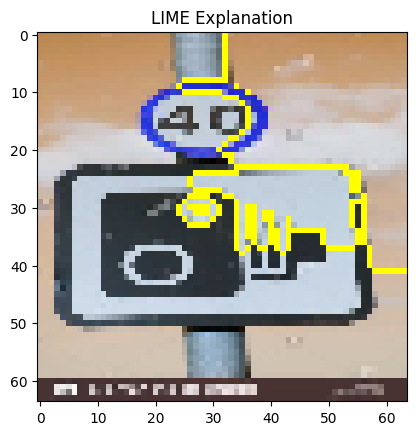

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  2%|▏         | 20/1000 [00:00<00:05, 168.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  5%|▌         | 50/1000 [00:00<00:04, 216.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  8%|▊         | 80/1000 [00:00<00:03, 231.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 11%|█         | 110/1000 [00:00<00:03, 241.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 14%|█▍        | 140/1000 [00:00<00:03, 246.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 17%|█▋        | 170/1000 [00:00<00:03, 247.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 20%|██        | 200/1000 [00:00<00:03, 251.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 23%|██▎       | 230/1000 [00:00<00:03, 253.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 26%|██▌       | 260/1000 [00:01<00:02, 252.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 29%|██▉       | 290/1000 [00:01<00:02, 250.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 32%|███▏      | 320/1000 [00:01<00:02, 253.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 35%|███▌      | 350/1000 [00:01<00:02, 253.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|███▊      | 380/1000 [00:01<00:02, 254.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 41%|████      | 410/1000 [00:01<00:02, 253.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 44%|████▍     | 440/1000 [00:01<00:02, 249.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 47%|████▋     | 470/1000 [00:01<00:02, 252.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 50%|█████     | 500/1000 [00:02<00:01, 253.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|█████▎    | 530/1000 [00:02<00:01, 254.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 56%|█████▌    | 560/1000 [00:02<00:01, 251.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|█████▉    | 590/1000 [00:02<00:01, 251.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 62%|██████▏   | 620/1000 [00:02<00:01, 254.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 65%|██████▌   | 650/1000 [00:02<00:01, 254.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 68%|██████▊   | 680/1000 [00:02<00:01, 252.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 71%|███████   | 710/1000 [00:02<00:01, 254.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 74%|███████▍  | 740/1000 [00:02<00:01, 255.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 77%|███████▋  | 770/1000 [00:03<00:00, 255.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|████████  | 800/1000 [00:03<00:00, 253.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 83%|████████▎ | 830/1000 [00:03<00:00, 255.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 86%|████████▌ | 860/1000 [00:03<00:00, 256.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 89%|████████▉ | 890/1000 [00:03<00:00, 257.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 92%|█████████▏| 920/1000 [00:03<00:00, 255.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 95%|█████████▌| 950/1000 [00:03<00:00, 241.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 98%|█████████▊| 980/1000 [00:03<00:00, 247.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


100%|██████████| 1000/1000 [00:03<00:00, 250.43it/s]


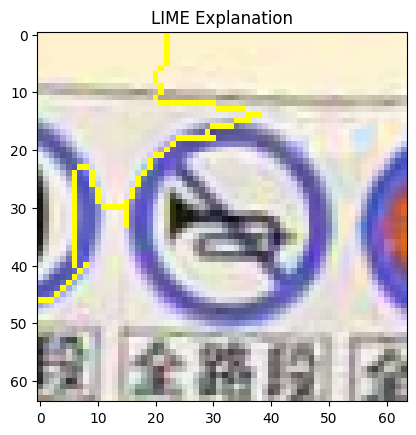

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


  3%|▎         | 30/1000 [00:00<00:03, 265.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  6%|▌         | 60/1000 [00:00<00:03, 268.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  9%|▉         | 90/1000 [00:00<00:03, 262.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 12%|█▏        | 120/1000 [00:00<00:03, 257.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 15%|█▌        | 150/1000 [00:00<00:03, 255.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 18%|█▊        | 180/1000 [00:00<00:03, 256.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|██        | 210/1000 [00:00<00:03, 257.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 24%|██▍       | 240/1000 [00:00<00:02, 256.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 27%|██▋       | 270/1000 [00:01<00:02, 255.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 30%|███       | 300/1000 [00:01<00:02, 257.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 33%|███▎      | 330/1000 [00:01<00:02, 253.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 36%|███▌      | 360/1000 [00:01<00:02, 253.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|███▉      | 390/1000 [00:01<00:02, 254.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 42%|████▏     | 420/1000 [00:01<00:02, 254.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 45%|████▌     | 450/1000 [00:01<00:02, 254.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 48%|████▊     | 480/1000 [00:01<00:02, 254.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 51%|█████     | 510/1000 [00:01<00:01, 255.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 54%|█████▍    | 540/1000 [00:02<00:01, 257.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 57%|█████▋    | 570/1000 [00:02<00:01, 258.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 60%|██████    | 600/1000 [00:02<00:01, 258.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 63%|██████▎   | 630/1000 [00:02<00:01, 257.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 66%|██████▌   | 660/1000 [00:02<00:01, 256.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 69%|██████▉   | 690/1000 [00:02<00:01, 254.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 72%|███████▏  | 720/1000 [00:02<00:01, 254.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 75%|███████▌  | 750/1000 [00:02<00:01, 241.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 78%|███████▊  | 780/1000 [00:03<00:00, 243.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 81%|████████  | 810/1000 [00:03<00:00, 246.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 84%|████████▍ | 840/1000 [00:03<00:00, 251.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 87%|████████▋ | 870/1000 [00:03<00:00, 253.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 90%|█████████ | 900/1000 [00:03<00:00, 255.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 93%|█████████▎| 930/1000 [00:03<00:00, 256.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 96%|█████████▌| 960/1000 [00:03<00:00, 257.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 99%|█████████▉| 990/1000 [00:03<00:00, 258.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


100%|██████████| 1000/1000 [00:03<00:00, 255.29it/s]


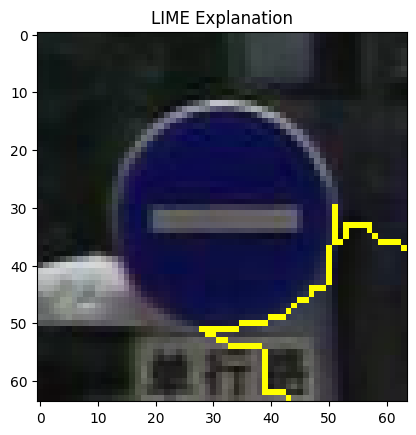

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  3%|▎         | 30/1000 [00:00<00:03, 267.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  6%|▌         | 60/1000 [00:00<00:03, 269.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


  9%|▉         | 90/1000 [00:00<00:03, 268.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 12%|█▏        | 120/1000 [00:00<00:03, 267.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 15%|█▌        | 150/1000 [00:00<00:03, 263.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 18%|█▊        | 180/1000 [00:00<00:03, 263.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|██        | 210/1000 [00:00<00:03, 262.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██▍       | 240/1000 [00:00<00:02, 259.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 27%|██▋       | 270/1000 [00:01<00:02, 258.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 30%|███       | 300/1000 [00:01<00:02, 260.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 33%|███▎      | 330/1000 [00:01<00:02, 262.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 36%|███▌      | 360/1000 [00:01<00:02, 245.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 39%|███▉      | 390/1000 [00:01<00:02, 249.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 42%|████▏     | 420/1000 [00:01<00:02, 254.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 45%|████▌     | 450/1000 [00:01<00:02, 257.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 48%|████▊     | 480/1000 [00:01<00:02, 257.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 51%|█████     | 510/1000 [00:01<00:01, 257.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 54%|█████▍    | 540/1000 [00:02<00:01, 255.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 57%|█████▋    | 570/1000 [00:02<00:01, 257.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|██████    | 600/1000 [00:02<00:01, 258.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 63%|██████▎   | 630/1000 [00:02<00:01, 260.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 66%|██████▌   | 660/1000 [00:02<00:01, 261.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 69%|██████▉   | 690/1000 [00:02<00:01, 265.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 72%|███████▏  | 720/1000 [00:02<00:01, 264.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 75%|███████▌  | 750/1000 [00:02<00:00, 264.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 78%|███████▊  | 780/1000 [00:03<00:00, 259.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 81%|████████  | 810/1000 [00:03<00:00, 261.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 84%|████████▎ | 837/1000 [00:03<00:00, 261.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 86%|████████▋ | 864/1000 [00:03<00:00, 250.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 89%|████████▉ | 890/1000 [00:03<00:00, 244.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 92%|█████████▏| 920/1000 [00:03<00:00, 251.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 95%|█████████▌| 950/1000 [00:03<00:00, 256.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 98%|█████████▊| 980/1000 [00:03<00:00, 257.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


100%|██████████| 1000/1000 [00:03<00:00, 258.63it/s]


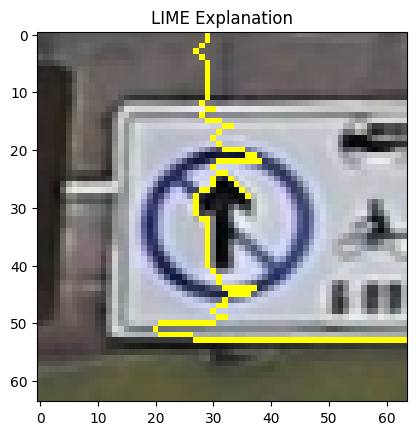

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  3%|▎         | 30/1000 [00:00<00:03, 245.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|▌         | 60/1000 [00:00<00:03, 261.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


  9%|▉         | 90/1000 [00:00<00:03, 264.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 12%|█▏        | 120/1000 [00:00<00:03, 266.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 15%|█▌        | 150/1000 [00:00<00:03, 264.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 18%|█▊        | 180/1000 [00:00<00:03, 265.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 21%|██        | 210/1000 [00:00<00:02, 268.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 24%|██▍       | 240/1000 [00:00<00:02, 270.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 27%|██▋       | 270/1000 [00:01<00:02, 270.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 30%|███       | 300/1000 [00:01<00:02, 269.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 33%|███▎      | 330/1000 [00:01<00:02, 270.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 36%|███▌      | 360/1000 [00:01<00:02, 274.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 39%|███▉      | 390/1000 [00:01<00:02, 271.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 42%|████▏     | 420/1000 [00:01<00:02, 266.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 45%|████▌     | 450/1000 [00:01<00:02, 263.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 48%|████▊     | 480/1000 [00:01<00:01, 267.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 51%|█████     | 510/1000 [00:01<00:01, 264.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 54%|█████▍    | 540/1000 [00:02<00:01, 265.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 57%|█████▋    | 570/1000 [00:02<00:01, 268.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 60%|█████▉    | 597/1000 [00:02<00:01, 266.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 62%|██████▏   | 624/1000 [00:02<00:01, 258.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 65%|██████▌   | 650/1000 [00:02<00:01, 250.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 68%|██████▊   | 680/1000 [00:02<00:01, 256.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 71%|███████   | 710/1000 [00:02<00:01, 262.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 74%|███████▍  | 740/1000 [00:02<00:00, 266.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 77%|███████▋  | 770/1000 [00:02<00:00, 267.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 80%|████████  | 800/1000 [00:03<00:00, 270.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 83%|████████▎ | 830/1000 [00:03<00:00, 270.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 86%|████████▌ | 860/1000 [00:03<00:00, 270.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 89%|████████▉ | 890/1000 [00:03<00:00, 268.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 92%|█████████▏| 920/1000 [00:03<00:00, 267.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 95%|█████████▌| 950/1000 [00:03<00:00, 270.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 98%|█████████▊| 980/1000 [00:03<00:00, 272.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


100%|██████████| 1000/1000 [00:03<00:00, 266.87it/s]


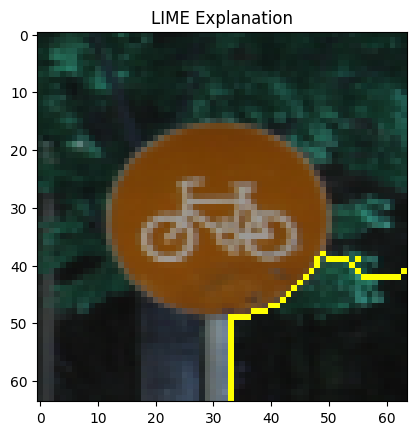

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


  3%|▎         | 30/1000 [00:00<00:03, 278.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  6%|▌         | 60/1000 [00:00<00:03, 279.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  9%|▉         | 90/1000 [00:00<00:03, 273.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 12%|█▏        | 120/1000 [00:00<00:03, 272.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 15%|█▌        | 150/1000 [00:00<00:03, 271.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 18%|█▊        | 180/1000 [00:00<00:03, 272.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 21%|██        | 210/1000 [00:00<00:02, 270.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 24%|██▍       | 240/1000 [00:00<00:02, 264.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 27%|██▋       | 270/1000 [00:01<00:02, 261.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 30%|███       | 300/1000 [00:01<00:02, 262.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 33%|███▎      | 330/1000 [00:01<00:02, 262.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 36%|███▌      | 357/1000 [00:01<00:02, 260.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 38%|███▊      | 384/1000 [00:01<00:02, 256.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 41%|████      | 410/1000 [00:01<00:02, 246.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 44%|████▍     | 440/1000 [00:01<00:02, 246.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 47%|████▋     | 470/1000 [00:01<00:02, 252.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 50%|█████     | 500/1000 [00:01<00:01, 255.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 53%|█████▎    | 530/1000 [00:02<00:01, 259.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 56%|█████▌    | 560/1000 [00:02<00:01, 259.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 59%|█████▉    | 590/1000 [00:02<00:01, 261.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 62%|██████▏   | 620/1000 [00:02<00:01, 264.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 65%|██████▌   | 650/1000 [00:02<00:01, 266.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 68%|██████▊   | 680/1000 [00:02<00:01, 265.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 71%|███████   | 710/1000 [00:02<00:01, 265.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 74%|███████▍  | 740/1000 [00:02<00:00, 264.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 77%|███████▋  | 770/1000 [00:02<00:00, 268.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|████████  | 800/1000 [00:03<00:00, 265.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 83%|████████▎ | 830/1000 [00:03<00:00, 262.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 86%|████████▌ | 860/1000 [00:03<00:00, 265.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 89%|████████▉ | 890/1000 [00:03<00:00, 267.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 92%|█████████▏| 920/1000 [00:03<00:00, 253.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 95%|█████████▌| 950/1000 [00:03<00:00, 255.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 98%|█████████▊| 980/1000 [00:03<00:00, 255.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


100%|██████████| 1000/1000 [00:03<00:00, 261.95it/s]


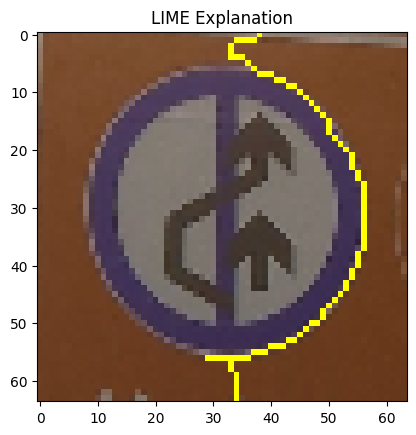

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  3%|▎         | 30/1000 [00:00<00:03, 255.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  6%|▌         | 56/1000 [00:00<00:04, 234.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  8%|▊         | 80/1000 [00:00<00:04, 223.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 11%|█         | 110/1000 [00:00<00:03, 238.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 14%|█▍        | 140/1000 [00:00<00:03, 243.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 17%|█▋        | 170/1000 [00:00<00:03, 249.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 20%|██        | 200/1000 [00:00<00:03, 253.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 23%|██▎       | 230/1000 [00:00<00:03, 253.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 26%|██▌       | 260/1000 [00:01<00:02, 253.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 29%|██▉       | 290/1000 [00:01<00:02, 254.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 32%|███▏      | 320/1000 [00:01<00:02, 258.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 35%|███▌      | 350/1000 [00:01<00:02, 256.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 38%|███▊      | 380/1000 [00:01<00:02, 253.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 41%|████      | 410/1000 [00:01<00:02, 254.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 44%|████▍     | 440/1000 [00:01<00:02, 256.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 47%|████▋     | 470/1000 [00:01<00:02, 254.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 50%|█████     | 500/1000 [00:01<00:01, 255.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 53%|█████▎    | 530/1000 [00:02<00:01, 259.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 56%|█████▌    | 560/1000 [00:02<00:01, 262.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|█████▉    | 590/1000 [00:02<00:01, 260.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 62%|██████▏   | 620/1000 [00:02<00:01, 262.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 65%|██████▌   | 650/1000 [00:02<00:01, 263.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 68%|██████▊   | 680/1000 [00:02<00:01, 267.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 71%|███████   | 710/1000 [00:02<00:01, 268.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 74%|███████▎  | 737/1000 [00:02<00:00, 267.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 76%|███████▋  | 764/1000 [00:02<00:00, 260.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 79%|███████▉  | 791/1000 [00:03<00:00, 257.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 82%|████████▏ | 820/1000 [00:03<00:00, 256.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 85%|████████▌ | 850/1000 [00:03<00:00, 260.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 88%|████████▊ | 880/1000 [00:03<00:00, 255.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 91%|█████████ | 910/1000 [00:03<00:00, 258.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 94%|█████████▍| 940/1000 [00:03<00:00, 256.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 97%|█████████▋| 970/1000 [00:03<00:00, 256.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


100%|██████████| 1000/1000 [00:03<00:00, 256.15it/s]


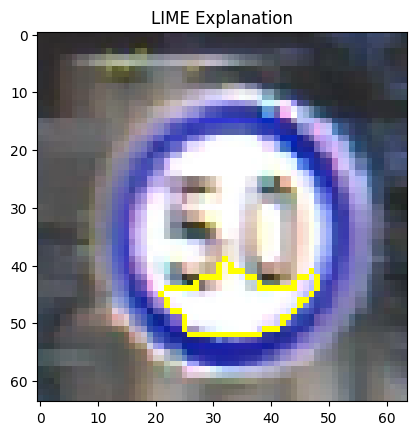

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  3%|▎         | 30/1000 [00:00<00:03, 269.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  6%|▌         | 60/1000 [00:00<00:03, 275.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  9%|▉         | 90/1000 [00:00<00:03, 264.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 12%|█▏        | 120/1000 [00:00<00:03, 262.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 15%|█▍        | 147/1000 [00:00<00:03, 261.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 17%|█▋        | 174/1000 [00:00<00:03, 255.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 20%|██        | 200/1000 [00:00<00:03, 250.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 23%|██▎       | 230/1000 [00:00<00:02, 260.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 26%|██▌       | 260/1000 [00:00<00:02, 261.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 29%|██▉       | 290/1000 [00:01<00:02, 264.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 32%|███▏      | 320/1000 [00:01<00:02, 264.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 35%|███▌      | 350/1000 [00:01<00:02, 266.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 38%|███▊      | 380/1000 [00:01<00:02, 265.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 41%|████      | 410/1000 [00:01<00:02, 268.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 44%|████▍     | 440/1000 [00:01<00:02, 271.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 47%|████▋     | 470/1000 [00:01<00:01, 272.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 50%|█████     | 500/1000 [00:01<00:01, 270.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 53%|█████▎    | 530/1000 [00:01<00:01, 268.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 56%|█████▌    | 560/1000 [00:02<00:01, 268.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 59%|█████▉    | 590/1000 [00:02<00:01, 269.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 62%|██████▏   | 620/1000 [00:02<00:01, 268.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 65%|██████▌   | 650/1000 [00:02<00:01, 269.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 68%|██████▊   | 680/1000 [00:02<00:01, 272.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 71%|███████   | 708/1000 [00:02<00:01, 272.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 74%|███████▎  | 736/1000 [00:02<00:00, 264.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 76%|███████▋  | 763/1000 [00:02<00:00, 258.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 79%|███████▉  | 790/1000 [00:02<00:00, 256.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 82%|████████▏ | 820/1000 [00:03<00:00, 262.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 85%|████████▌ | 850/1000 [00:03<00:00, 261.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 88%|████████▊ | 880/1000 [00:03<00:00, 258.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 91%|█████████ | 910/1000 [00:03<00:00, 262.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 94%|█████████▍| 940/1000 [00:03<00:00, 267.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 97%|█████████▋| 970/1000 [00:03<00:00, 269.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


100%|██████████| 1000/1000 [00:03<00:00, 265.68it/s]


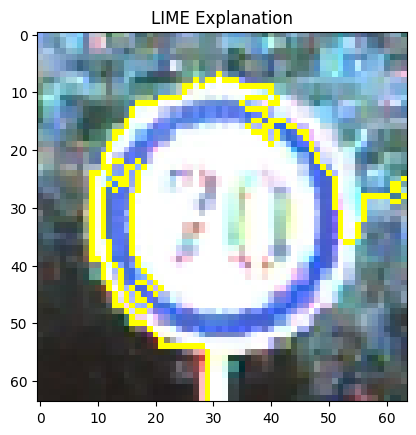

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


  3%|▎         | 30/1000 [00:00<00:03, 270.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


  6%|▌         | 60/1000 [00:00<00:03, 277.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


  9%|▉         | 90/1000 [00:00<00:03, 278.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 12%|█▏        | 120/1000 [00:00<00:03, 276.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 15%|█▌        | 150/1000 [00:00<00:03, 273.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 18%|█▊        | 180/1000 [00:00<00:02, 274.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 21%|██        | 210/1000 [00:00<00:02, 276.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 24%|██▍       | 240/1000 [00:00<00:02, 275.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 27%|██▋       | 270/1000 [00:00<00:02, 274.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


 30%|███       | 300/1000 [00:01<00:02, 272.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 33%|███▎      | 328/1000 [00:01<00:02, 274.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 36%|███▌      | 356/1000 [00:01<00:02, 269.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 38%|███▊      | 383/1000 [00:01<00:02, 259.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 41%|████      | 410/1000 [00:01<00:02, 247.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 44%|████▍     | 440/1000 [00:01<00:02, 250.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 47%|████▋     | 470/1000 [00:01<00:02, 254.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 50%|█████     | 500/1000 [00:01<00:01, 261.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 53%|█████▎    | 530/1000 [00:01<00:01, 263.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 56%|█████▌    | 560/1000 [00:02<00:01, 267.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 59%|█████▉    | 590/1000 [00:02<00:01, 270.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 62%|██████▏   | 620/1000 [00:02<00:01, 266.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 65%|██████▌   | 650/1000 [00:02<00:01, 262.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 68%|██████▊   | 680/1000 [00:02<00:01, 261.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 71%|███████   | 710/1000 [00:02<00:01, 256.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 74%|███████▍  | 740/1000 [00:02<00:00, 262.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 77%|███████▋  | 770/1000 [00:02<00:00, 262.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|████████  | 800/1000 [00:03<00:00, 262.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 83%|████████▎ | 830/1000 [00:03<00:00, 262.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 86%|████████▌ | 860/1000 [00:03<00:00, 261.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 89%|████████▉ | 890/1000 [00:03<00:00, 260.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 92%|█████████▏| 917/1000 [00:03<00:00, 260.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 94%|█████████▍| 944/1000 [00:03<00:00, 253.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 97%|█████████▋| 970/1000 [00:03<00:00, 244.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


100%|██████████| 1000/1000 [00:03<00:00, 262.78it/s]


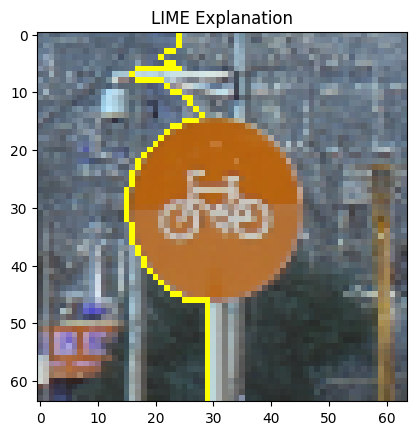

In [21]:
explainer = lime_image.LimeImageExplainer()

# Pick images from the test set and get the explanation for it
for i in range(21,30):
    explanation = explainer.explain_instance(X_new[i], cnn_model2.predict, top_labels=23, hide_color=0, num_samples=1000)

# Get image and mask for a given label
    temp, mask = explanation.get_image_and_mask(y_new[i], positive_only=True, num_features=5, hide_rest=False)

# Visualize the image explanation
    plt.imshow(mark_boundaries(temp, mask))
    plt.title('LIME Explanation')
    plt.show()


## Fine-tuned Model

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  3%|▎         | 30/1000 [00:00<00:03, 261.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  6%|▌         | 60/1000 [00:00<00:03, 263.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  9%|▉         | 90/1000 [00:00<00:03, 266.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 12%|█▏        | 120/1000 [00:00<00:03, 254.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 15%|█▌        | 150/1000 [00:00<00:03, 257.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 18%|█▊        | 180/1000 [00:00<00:03, 253.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 21%|██        | 210/1000 [00:00<00:03, 254.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██▍       | 240/1000 [00:00<00:03, 252.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 27%|██▋       | 270/1000 [00:01<00:02, 255.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 30%|███       | 300/1000 [00:01<00:02, 255.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 33%|███▎      | 330/1000 [00:01<00:02, 254.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 36%|███▌      | 360/1000 [00:01<00:02, 255.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 39%|███▉      | 390/1000 [00:01<00:02, 258.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 42%|████▏     | 420/1000 [00:01<00:02, 255.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 45%|████▌     | 450/1000 [00:01<00:02, 260.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 48%|████▊     | 480/1000 [00:01<00:02, 257.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 51%|█████     | 510/1000 [00:01<00:01, 261.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|█████▍    | 540/1000 [00:02<00:01, 259.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 57%|█████▋    | 570/1000 [00:02<00:01, 259.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 60%|██████    | 600/1000 [00:02<00:01, 262.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 63%|██████▎   | 630/1000 [00:02<00:01, 261.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 66%|██████▌   | 660/1000 [00:02<00:01, 262.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 69%|██████▉   | 690/1000 [00:02<00:01, 263.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 72%|███████▏  | 720/1000 [00:02<00:01, 264.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 75%|███████▌  | 750/1000 [00:02<00:00, 265.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 78%|███████▊  | 780/1000 [00:03<00:00, 265.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 81%|████████  | 810/1000 [00:03<00:00, 266.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 84%|████████▍ | 840/1000 [00:03<00:00, 257.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 87%|████████▋ | 870/1000 [00:03<00:00, 258.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 90%|█████████ | 900/1000 [00:03<00:00, 259.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 93%|█████████▎| 930/1000 [00:03<00:00, 261.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 96%|█████████▌| 960/1000 [00:03<00:00, 260.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 99%|█████████▉| 990/1000 [00:03<00:00, 261.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


100%|██████████| 1000/1000 [00:03<00:00, 257.87it/s]


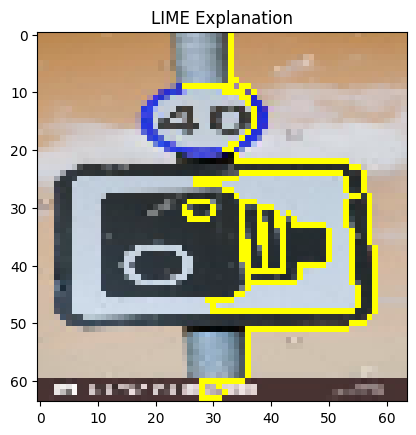

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  3%|▎         | 30/1000 [00:00<00:03, 267.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


  6%|▌         | 60/1000 [00:00<00:03, 272.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  9%|▉         | 90/1000 [00:00<00:03, 265.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 12%|█▏        | 120/1000 [00:00<00:03, 262.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 15%|█▌        | 150/1000 [00:00<00:03, 262.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 18%|█▊        | 180/1000 [00:00<00:03, 262.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|██        | 210/1000 [00:00<00:03, 254.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 24%|██▍       | 240/1000 [00:00<00:02, 258.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 27%|██▋       | 270/1000 [00:01<00:02, 258.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 30%|███       | 300/1000 [00:01<00:02, 260.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 33%|███▎      | 330/1000 [00:01<00:02, 253.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 36%|███▌      | 360/1000 [00:01<00:02, 254.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 39%|███▉      | 390/1000 [00:01<00:02, 255.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 42%|████▏     | 420/1000 [00:01<00:02, 258.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 45%|████▌     | 450/1000 [00:01<00:02, 257.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 48%|████▊     | 480/1000 [00:01<00:02, 256.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 51%|█████     | 510/1000 [00:01<00:01, 257.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|█████▍    | 540/1000 [00:02<00:01, 257.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 57%|█████▋    | 570/1000 [00:02<00:01, 255.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 60%|██████    | 600/1000 [00:02<00:01, 260.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 63%|██████▎   | 630/1000 [00:02<00:01, 255.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 66%|██████▌   | 660/1000 [00:02<00:01, 258.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 69%|██████▉   | 690/1000 [00:02<00:01, 256.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 72%|███████▏  | 720/1000 [00:02<00:01, 255.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 75%|███████▌  | 750/1000 [00:02<00:00, 258.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 78%|███████▊  | 780/1000 [00:03<00:00, 252.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 81%|████████  | 810/1000 [00:03<00:00, 255.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 84%|████████▍ | 840/1000 [00:03<00:00, 258.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 87%|████████▋ | 870/1000 [00:03<00:00, 259.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 90%|█████████ | 900/1000 [00:03<00:00, 259.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 93%|█████████▎| 930/1000 [00:03<00:00, 258.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 96%|█████████▌| 960/1000 [00:03<00:00, 258.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 99%|█████████▉| 990/1000 [00:03<00:00, 260.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


100%|██████████| 1000/1000 [00:03<00:00, 258.49it/s]


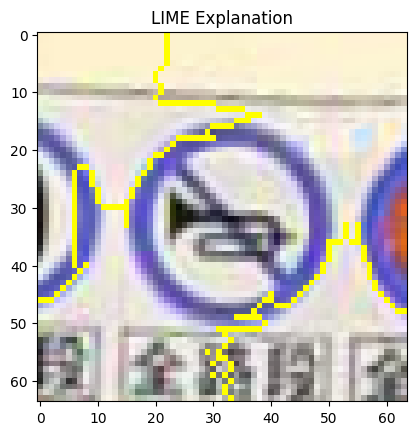

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  3%|▎         | 30/1000 [00:00<00:03, 273.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|▌         | 60/1000 [00:00<00:03, 268.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  9%|▉         | 90/1000 [00:00<00:03, 267.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 12%|█▏        | 120/1000 [00:00<00:03, 259.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 15%|█▌        | 150/1000 [00:00<00:03, 259.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 18%|█▊        | 177/1000 [00:00<00:03, 259.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 20%|██        | 203/1000 [00:00<00:03, 245.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 23%|██▎       | 230/1000 [00:00<00:03, 243.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 26%|██▌       | 260/1000 [00:01<00:02, 246.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 29%|██▉       | 290/1000 [00:01<00:02, 249.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 32%|███▏      | 320/1000 [00:01<00:02, 254.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 35%|███▌      | 350/1000 [00:01<00:02, 257.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|███▊      | 380/1000 [00:01<00:02, 256.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 41%|████      | 410/1000 [00:01<00:02, 255.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 44%|████▍     | 440/1000 [00:01<00:02, 257.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 47%|████▋     | 470/1000 [00:01<00:02, 257.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 50%|█████     | 500/1000 [00:01<00:01, 257.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 53%|█████▎    | 530/1000 [00:02<00:01, 261.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 56%|█████▌    | 560/1000 [00:02<00:01, 262.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 59%|█████▉    | 590/1000 [00:02<00:01, 265.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 62%|██████▏   | 620/1000 [00:02<00:01, 264.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 65%|██████▌   | 650/1000 [00:02<00:01, 255.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 68%|██████▊   | 680/1000 [00:02<00:01, 258.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 71%|███████   | 710/1000 [00:02<00:01, 259.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 74%|███████▍  | 740/1000 [00:02<00:01, 255.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 77%|███████▋  | 770/1000 [00:02<00:00, 257.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 80%|████████  | 800/1000 [00:03<00:00, 260.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 83%|████████▎ | 830/1000 [00:03<00:00, 259.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 86%|████████▌ | 860/1000 [00:03<00:00, 261.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 89%|████████▉ | 890/1000 [00:03<00:00, 261.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 92%|█████████▏| 920/1000 [00:03<00:00, 260.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 95%|█████████▌| 950/1000 [00:03<00:00, 260.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 98%|█████████▊| 980/1000 [00:03<00:00, 256.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


100%|██████████| 1000/1000 [00:03<00:00, 257.93it/s]


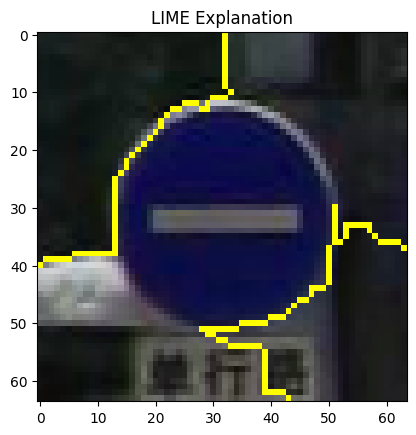

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  3%|▎         | 30/1000 [00:00<00:03, 258.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  6%|▌         | 60/1000 [00:00<00:03, 261.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|▉         | 90/1000 [00:00<00:03, 249.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 12%|█▏        | 120/1000 [00:00<00:03, 254.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 15%|█▌        | 150/1000 [00:00<00:03, 252.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 18%|█▊        | 176/1000 [00:00<00:03, 252.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 20%|██        | 202/1000 [00:00<00:03, 245.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 23%|██▎       | 230/1000 [00:00<00:03, 245.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 26%|██▌       | 260/1000 [00:01<00:02, 251.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 29%|██▉       | 290/1000 [00:01<00:02, 255.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 32%|███▏      | 320/1000 [00:01<00:02, 259.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 35%|███▌      | 350/1000 [00:01<00:02, 256.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|███▊      | 380/1000 [00:01<00:02, 256.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 41%|████      | 410/1000 [00:01<00:02, 257.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 44%|████▍     | 440/1000 [00:01<00:02, 260.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 47%|████▋     | 470/1000 [00:01<00:02, 262.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 50%|█████     | 500/1000 [00:01<00:01, 264.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 53%|█████▎    | 530/1000 [00:02<00:01, 260.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 56%|█████▌    | 560/1000 [00:02<00:01, 262.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 59%|█████▉    | 590/1000 [00:02<00:01, 263.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 62%|██████▏   | 620/1000 [00:02<00:01, 264.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 65%|██████▌   | 650/1000 [00:02<00:01, 262.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 68%|██████▊   | 680/1000 [00:02<00:01, 264.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 71%|███████   | 710/1000 [00:02<00:01, 263.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 74%|███████▍  | 740/1000 [00:02<00:00, 265.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 77%|███████▋  | 770/1000 [00:02<00:00, 259.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 80%|████████  | 800/1000 [00:03<00:00, 257.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 83%|████████▎ | 830/1000 [00:03<00:00, 257.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 86%|████████▌ | 860/1000 [00:03<00:00, 258.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 89%|████████▉ | 890/1000 [00:03<00:00, 255.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 92%|█████████▏| 920/1000 [00:03<00:00, 253.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 95%|█████████▌| 950/1000 [00:03<00:00, 255.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 98%|█████████▊| 980/1000 [00:03<00:00, 258.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


100%|██████████| 1000/1000 [00:03<00:00, 257.69it/s]


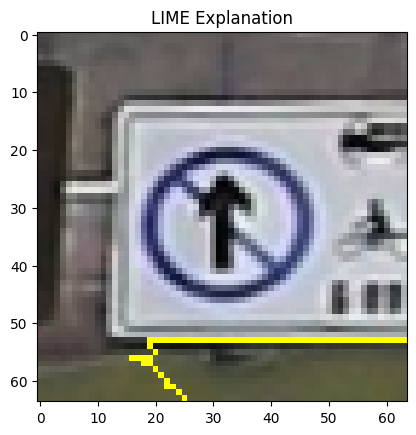

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  3%|▎         | 30/1000 [00:00<00:03, 265.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  6%|▌         | 60/1000 [00:00<00:04, 232.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  9%|▉         | 90/1000 [00:00<00:03, 244.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 12%|█▏        | 120/1000 [00:00<00:03, 246.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 15%|█▌        | 150/1000 [00:00<00:03, 255.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 18%|█▊        | 180/1000 [00:00<00:03, 256.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 21%|██        | 210/1000 [00:00<00:03, 259.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|██▍       | 240/1000 [00:00<00:02, 256.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 27%|██▋       | 270/1000 [00:01<00:02, 256.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 30%|███       | 300/1000 [00:01<00:02, 256.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 33%|███▎      | 330/1000 [00:01<00:02, 259.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 36%|███▌      | 360/1000 [00:01<00:02, 262.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 39%|███▉      | 390/1000 [00:01<00:02, 260.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 42%|████▏     | 420/1000 [00:01<00:02, 257.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 45%|████▌     | 450/1000 [00:01<00:02, 257.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 48%|████▊     | 480/1000 [00:01<00:02, 259.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 51%|█████     | 510/1000 [00:01<00:01, 258.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 54%|█████▍    | 540/1000 [00:02<00:01, 253.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 57%|█████▋    | 570/1000 [00:02<00:01, 253.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|██████    | 600/1000 [00:02<00:01, 254.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 63%|██████▎   | 630/1000 [00:02<00:01, 254.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 66%|██████▌   | 660/1000 [00:02<00:01, 256.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 69%|██████▉   | 690/1000 [00:02<00:01, 256.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 72%|███████▏  | 720/1000 [00:02<00:01, 257.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 75%|███████▌  | 750/1000 [00:02<00:00, 257.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 78%|███████▊  | 780/1000 [00:03<00:00, 257.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 81%|████████  | 810/1000 [00:03<00:00, 256.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 84%|████████▍ | 840/1000 [00:03<00:00, 255.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 87%|████████▋ | 870/1000 [00:03<00:00, 260.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 90%|████████▉ | 897/1000 [00:03<00:00, 262.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 92%|█████████▏| 924/1000 [00:03<00:00, 254.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 95%|█████████▌| 950/1000 [00:03<00:00, 240.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 98%|█████████▊| 980/1000 [00:03<00:00, 247.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


100%|██████████| 1000/1000 [00:03<00:00, 254.95it/s]


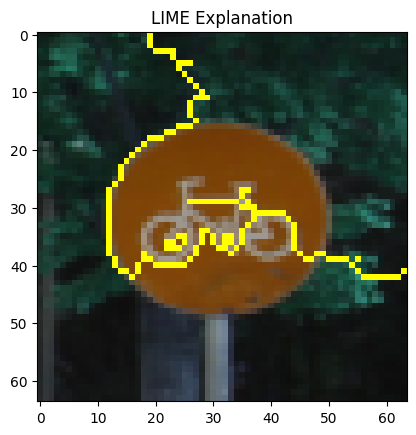

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  3%|▎         | 30/1000 [00:00<00:03, 266.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  6%|▌         | 60/1000 [00:00<00:03, 267.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  9%|▉         | 90/1000 [00:00<00:03, 259.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 12%|█▏        | 117/1000 [00:00<00:09, 97.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 14%|█▍        | 140/1000 [00:01<00:07, 115.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█▋        | 170/1000 [00:01<00:05, 142.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 20%|██        | 200/1000 [00:01<00:04, 169.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 23%|██▎       | 230/1000 [00:01<00:04, 189.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 26%|██▌       | 260/1000 [00:01<00:03, 208.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 29%|██▉       | 290/1000 [00:01<00:03, 218.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 32%|███▏      | 320/1000 [00:01<00:02, 227.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 35%|███▌      | 350/1000 [00:01<00:02, 234.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|███▊      | 380/1000 [00:01<00:02, 243.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 41%|████      | 410/1000 [00:02<00:02, 249.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 44%|████▍     | 440/1000 [00:02<00:02, 252.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 47%|████▋     | 470/1000 [00:02<00:02, 250.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 50%|█████     | 500/1000 [00:02<00:01, 251.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 53%|█████▎    | 530/1000 [00:02<00:01, 255.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 56%|█████▌    | 556/1000 [00:02<00:01, 248.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 58%|█████▊    | 581/1000 [00:02<00:01, 240.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 61%|██████    | 610/1000 [00:02<00:01, 246.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 64%|██████▍   | 640/1000 [00:03<00:01, 252.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 67%|██████▋   | 670/1000 [00:03<00:01, 255.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 70%|███████   | 700/1000 [00:03<00:01, 255.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 73%|███████▎  | 730/1000 [00:03<00:01, 259.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 76%|███████▌  | 760/1000 [00:03<00:00, 262.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 79%|███████▉  | 790/1000 [00:03<00:00, 262.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 82%|████████▏ | 820/1000 [00:03<00:00, 262.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 85%|████████▌ | 850/1000 [00:03<00:00, 263.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 88%|████████▊ | 880/1000 [00:03<00:00, 262.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 91%|█████████ | 910/1000 [00:04<00:00, 249.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 94%|█████████▍| 940/1000 [00:04<00:00, 247.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 97%|█████████▋| 970/1000 [00:04<00:00, 248.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


100%|██████████| 1000/1000 [00:04<00:00, 226.15it/s]


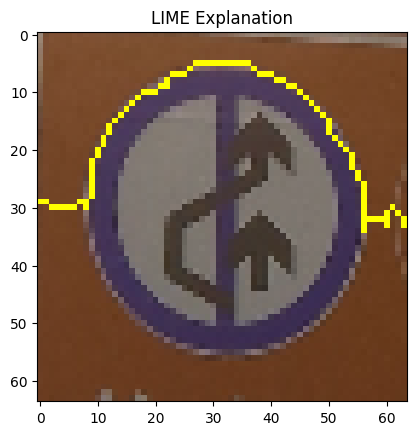

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|▎         | 30/1000 [00:00<00:04, 241.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  6%|▌         | 60/1000 [00:00<00:03, 248.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|▉         | 90/1000 [00:00<00:03, 247.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 12%|█▏        | 120/1000 [00:00<00:03, 251.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 15%|█▌        | 150/1000 [00:00<00:03, 252.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 18%|█▊        | 180/1000 [00:00<00:03, 255.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 21%|██        | 210/1000 [00:00<00:03, 254.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 24%|██▍       | 240/1000 [00:00<00:03, 253.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 27%|██▋       | 266/1000 [00:01<00:02, 246.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 29%|██▉       | 291/1000 [00:01<00:03, 234.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 32%|███▏      | 320/1000 [00:01<00:02, 237.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|███▌      | 350/1000 [00:01<00:02, 241.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 38%|███▊      | 380/1000 [00:01<00:02, 244.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 41%|████      | 410/1000 [00:01<00:02, 246.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 44%|████▍     | 440/1000 [00:01<00:02, 245.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 47%|████▋     | 470/1000 [00:01<00:02, 245.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 50%|█████     | 500/1000 [00:02<00:02, 246.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|█████▎    | 530/1000 [00:02<00:01, 249.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 56%|█████▌    | 560/1000 [00:02<00:01, 254.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 59%|█████▉    | 590/1000 [00:02<00:01, 255.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 62%|██████▏   | 620/1000 [00:02<00:01, 252.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 65%|██████▌   | 650/1000 [00:02<00:01, 255.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 68%|██████▊   | 680/1000 [00:02<00:01, 254.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 71%|███████   | 710/1000 [00:02<00:01, 255.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 74%|███████▍  | 740/1000 [00:02<00:01, 252.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 77%|███████▋  | 770/1000 [00:03<00:00, 251.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 80%|████████  | 800/1000 [00:03<00:00, 251.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 83%|████████▎ | 830/1000 [00:03<00:00, 251.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 86%|████████▌ | 860/1000 [00:03<00:00, 249.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 89%|████████▉ | 890/1000 [00:03<00:00, 248.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 92%|█████████▏| 920/1000 [00:03<00:00, 247.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 95%|█████████▌| 950/1000 [00:03<00:00, 248.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 98%|█████████▊| 980/1000 [00:03<00:00, 246.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


100%|██████████| 1000/1000 [00:04<00:00, 247.21it/s]


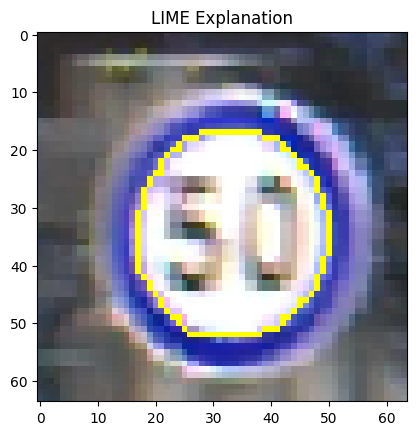

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|▎         | 30/1000 [00:00<00:03, 249.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  6%|▌         | 60/1000 [00:00<00:03, 247.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  9%|▉         | 90/1000 [00:00<00:03, 249.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 12%|█▏        | 120/1000 [00:00<00:03, 246.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 15%|█▌        | 150/1000 [00:00<00:03, 248.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 18%|█▊        | 180/1000 [00:00<00:03, 250.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 21%|██        | 210/1000 [00:00<00:03, 251.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 24%|██▍       | 240/1000 [00:00<00:03, 251.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 27%|██▋       | 270/1000 [00:01<00:02, 248.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 30%|███       | 300/1000 [00:01<00:02, 249.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 33%|███▎      | 330/1000 [00:01<00:02, 249.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 36%|███▌      | 360/1000 [00:01<00:02, 247.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 39%|███▉      | 390/1000 [00:01<00:02, 249.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 42%|████▏     | 420/1000 [00:01<00:02, 248.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 45%|████▌     | 450/1000 [00:01<00:02, 252.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 48%|████▊     | 476/1000 [00:01<00:02, 247.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 50%|█████     | 501/1000 [00:02<00:02, 238.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 53%|█████▎    | 530/1000 [00:02<00:02, 232.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 56%|█████▌    | 560/1000 [00:02<00:01, 237.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 59%|█████▉    | 590/1000 [00:02<00:01, 242.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 62%|██████▏   | 620/1000 [00:02<00:01, 243.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 65%|██████▌   | 650/1000 [00:02<00:01, 246.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 68%|██████▊   | 680/1000 [00:02<00:01, 249.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 71%|███████   | 710/1000 [00:02<00:01, 251.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 74%|███████▍  | 740/1000 [00:02<00:01, 252.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 77%|███████▋  | 770/1000 [00:03<00:00, 249.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|████████  | 800/1000 [00:03<00:00, 252.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 83%|████████▎ | 830/1000 [00:03<00:00, 250.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 86%|████████▌ | 860/1000 [00:03<00:00, 250.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 89%|████████▉ | 890/1000 [00:03<00:00, 248.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 92%|█████████▏| 920/1000 [00:03<00:00, 242.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 95%|█████████▌| 950/1000 [00:03<00:00, 236.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 98%|█████████▊| 980/1000 [00:03<00:00, 237.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


100%|██████████| 1000/1000 [00:04<00:00, 245.92it/s]


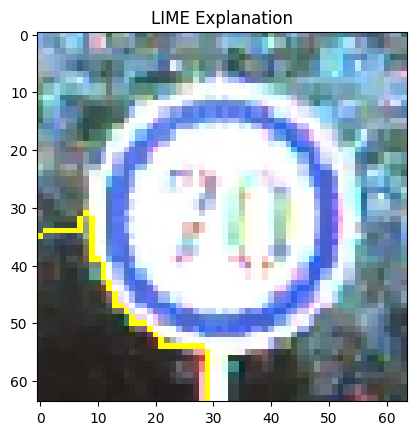

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  3%|▎         | 30/1000 [00:00<00:03, 259.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  6%|▌         | 60/1000 [00:00<00:03, 265.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  9%|▊         | 87/1000 [00:00<00:03, 255.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 11%|█▏        | 113/1000 [00:00<00:03, 241.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 14%|█▍        | 140/1000 [00:00<00:03, 233.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█▋        | 170/1000 [00:00<00:03, 240.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 20%|██        | 200/1000 [00:00<00:03, 244.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 23%|██▎       | 230/1000 [00:00<00:03, 250.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 26%|██▌       | 260/1000 [00:01<00:02, 252.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 29%|██▉       | 290/1000 [00:01<00:02, 254.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 32%|███▏      | 320/1000 [00:01<00:02, 253.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|███▌      | 350/1000 [00:01<00:02, 252.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|███▊      | 380/1000 [00:01<00:02, 247.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 41%|████      | 410/1000 [00:01<00:02, 252.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 44%|████▍     | 440/1000 [00:01<00:02, 251.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 47%|████▋     | 470/1000 [00:01<00:02, 252.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 50%|█████     | 500/1000 [00:01<00:01, 253.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 53%|█████▎    | 530/1000 [00:02<00:01, 251.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 56%|█████▌    | 560/1000 [00:02<00:01, 251.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 59%|█████▉    | 590/1000 [00:02<00:01, 237.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 62%|██████▏   | 620/1000 [00:02<00:01, 241.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 65%|██████▌   | 650/1000 [00:02<00:01, 247.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 68%|██████▊   | 680/1000 [00:02<00:01, 246.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 71%|███████   | 710/1000 [00:02<00:01, 244.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 74%|███████▍  | 740/1000 [00:02<00:01, 246.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 77%|███████▋  | 770/1000 [00:03<00:00, 249.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 80%|████████  | 800/1000 [00:03<00:00, 251.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 83%|████████▎ | 830/1000 [00:03<00:00, 254.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 86%|████████▌ | 860/1000 [00:03<00:00, 255.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 89%|████████▉ | 890/1000 [00:03<00:00, 255.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 92%|█████████▏| 920/1000 [00:03<00:00, 254.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 95%|█████████▌| 950/1000 [00:03<00:00, 254.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 98%|█████████▊| 980/1000 [00:03<00:00, 256.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


100%|██████████| 1000/1000 [00:03<00:00, 250.44it/s]


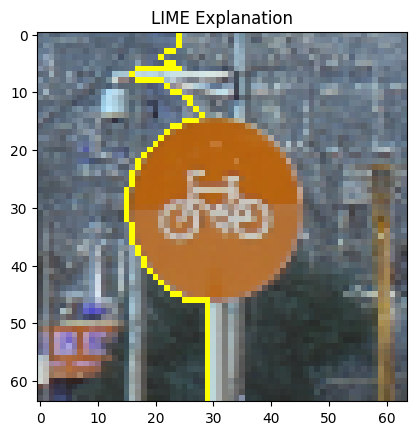

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  3%|▎         | 30/1000 [00:00<00:03, 256.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  6%|▌         | 60/1000 [00:00<00:03, 256.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  9%|▉         | 90/1000 [00:00<00:03, 256.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 12%|█▏        | 120/1000 [00:00<00:03, 254.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 15%|█▍        | 146/1000 [00:00<00:03, 251.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 17%|█▋        | 172/1000 [00:00<00:03, 242.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 20%|██        | 200/1000 [00:00<00:03, 242.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 23%|██▎       | 230/1000 [00:00<00:03, 245.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 26%|██▌       | 260/1000 [00:01<00:02, 249.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 29%|██▉       | 290/1000 [00:01<00:02, 252.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 32%|███▏      | 320/1000 [00:01<00:02, 255.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 35%|███▌      | 350/1000 [00:01<00:02, 255.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|███▊      | 380/1000 [00:01<00:02, 257.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 41%|████      | 410/1000 [00:01<00:02, 259.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 44%|████▍     | 440/1000 [00:01<00:02, 260.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 47%|████▋     | 470/1000 [00:01<00:02, 258.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 50%|█████     | 500/1000 [00:01<00:01, 256.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 53%|█████▎    | 530/1000 [00:02<00:01, 255.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 56%|█████▌    | 560/1000 [00:02<00:01, 256.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 59%|█████▉    | 590/1000 [00:02<00:01, 255.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 62%|██████▏   | 620/1000 [00:02<00:01, 256.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 65%|██████▌   | 650/1000 [00:02<00:01, 254.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 68%|██████▊   | 680/1000 [00:02<00:01, 253.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 71%|███████   | 706/1000 [00:02<00:01, 248.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 73%|███████▎  | 731/1000 [00:02<00:01, 238.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 76%|███████▌  | 760/1000 [00:03<00:01, 236.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 79%|███████▉  | 790/1000 [00:03<00:00, 241.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 82%|████████▏ | 820/1000 [00:03<00:00, 240.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 85%|████████▌ | 850/1000 [00:03<00:00, 243.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 88%|████████▊ | 880/1000 [00:03<00:00, 246.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 91%|█████████ | 910/1000 [00:03<00:00, 243.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 94%|█████████▍| 940/1000 [00:03<00:00, 243.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 97%|█████████▋| 970/1000 [00:03<00:00, 242.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


100%|██████████| 1000/1000 [00:04<00:00, 248.97it/s]


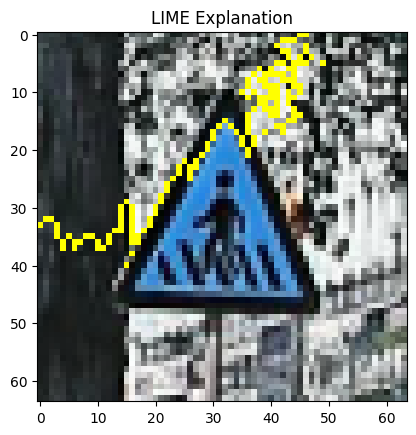

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  2%|▏         | 20/1000 [00:00<00:05, 181.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|▌         | 50/1000 [00:00<00:04, 223.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  8%|▊         | 80/1000 [00:00<00:03, 235.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 11%|█         | 110/1000 [00:00<00:03, 241.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 14%|█▍        | 140/1000 [00:00<00:03, 243.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 17%|█▋        | 170/1000 [00:00<00:03, 242.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 20%|██        | 200/1000 [00:00<00:03, 239.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 23%|██▎       | 230/1000 [00:00<00:03, 243.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 26%|██▌       | 260/1000 [00:01<00:02, 247.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 29%|██▉       | 290/1000 [00:01<00:02, 251.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 32%|███▏      | 320/1000 [00:01<00:02, 254.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 35%|███▌      | 350/1000 [00:01<00:02, 257.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 38%|███▊      | 380/1000 [00:01<00:02, 254.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 41%|████      | 410/1000 [00:01<00:02, 255.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 44%|████▍     | 440/1000 [00:01<00:02, 257.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 47%|████▋     | 466/1000 [00:01<00:02, 253.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 49%|████▉     | 492/1000 [00:02<00:02, 242.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 52%|█████▏    | 520/1000 [00:02<00:01, 243.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 55%|█████▌    | 550/1000 [00:02<00:01, 245.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 58%|█████▊    | 580/1000 [00:02<00:01, 247.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 61%|██████    | 610/1000 [00:02<00:01, 248.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 64%|██████▍   | 640/1000 [00:02<00:01, 251.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 67%|██████▋   | 670/1000 [00:02<00:01, 254.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 70%|███████   | 700/1000 [00:02<00:01, 254.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 73%|███████▎  | 730/1000 [00:02<00:01, 254.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 76%|███████▌  | 760/1000 [00:03<00:00, 254.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 79%|███████▉  | 790/1000 [00:03<00:00, 253.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 82%|████████▏ | 820/1000 [00:03<00:00, 254.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 85%|████████▌ | 850/1000 [00:03<00:00, 254.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 88%|████████▊ | 876/1000 [00:03<00:00, 251.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 90%|█████████ | 902/1000 [00:03<00:00, 242.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 93%|█████████▎| 930/1000 [00:03<00:00, 242.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 96%|█████████▌| 960/1000 [00:03<00:00, 246.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 99%|█████████▉| 990/1000 [00:03<00:00, 248.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


100%|██████████| 1000/1000 [00:04<00:00, 248.32it/s]


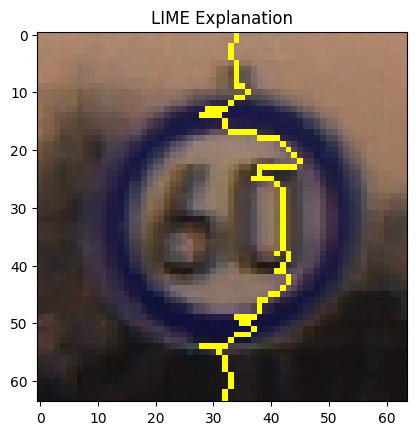

In [22]:
explainer = lime_image.LimeImageExplainer()
# Pick an image from the test set and get the explanation for it
for i in range(21,32):
    explanation = explainer.explain_instance(X_new[i], cnn_model.predict, top_labels=23, hide_color=0, num_samples=1000)

# Get image and mask for a given label
    temp, mask = explanation.get_image_and_mask(y_new[i], positive_only=True, num_features=5, hide_rest=False)

# Visualize the image explanation
    plt.imshow(mark_boundaries(temp, mask))
    plt.title('LIME Explanation')
    plt.show()

# Pretrained model

In [23]:
def build_pretrained_model(input_shape, num_classes):
    pre_trained_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Freezing base model layers
    pre_trained_model.trainable = False
    
    model = Sequential([
        pre_trained_model,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    return model

# Compile the model
pretrained_model = build_pretrained_model(input_shape = (IMG_SIZE, IMG_SIZE, 3), num_classes = len(np.unique(y)))
pretrained_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
pretrained_model.fit(datagen.flow(X_train, y_train, batch_size=32), epochs=10, validation_data=(X_test, y_test))


/Users/ryan/Documents/GitHub/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 25s 192ms/step - accuracy: 0.0617 - loss: 3.4408 - val_accuracy: 0.1051 - val_loss: 3.0713
Epoch 2/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 20s 184ms/step - accuracy: 0.0995 - loss: 3.1207 - val_accuracy: 0.1051 - val_loss: 3.0453
Epoch 3/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 20s 183ms/step - accuracy: 0.1024 - loss: 3.0852 - val_accuracy: 0.1051 - val_loss: 3.0363
Epoch 4/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 20s 176ms/step - accuracy: 0.1052 - loss: 3.0568 - val_accuracy: 0.1051 - val_loss: 3.0416
Epoch 5/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 20s 181ms/step - accuracy: 0.0930 - loss: 3.0882 - val_accuracy: 0.1051 - val_loss: 3.0521
Epoch 6/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 20s 186ms/step - accuracy: 0.1008 - loss: 3.0576 - val_accuracy: 0.1051 - val_loss: 3.0475
Epoch 7/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 20s 184ms/step - accuracy: 0.0936 - loss: 3.0585 - val_accuracy: 0.1051 - val_loss: 3.0393
Epoch 8/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 21s 187ms/step - accuracy: 0.1008 - loss: 3

## Internal Dataset Result - Pretrained Model

31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step


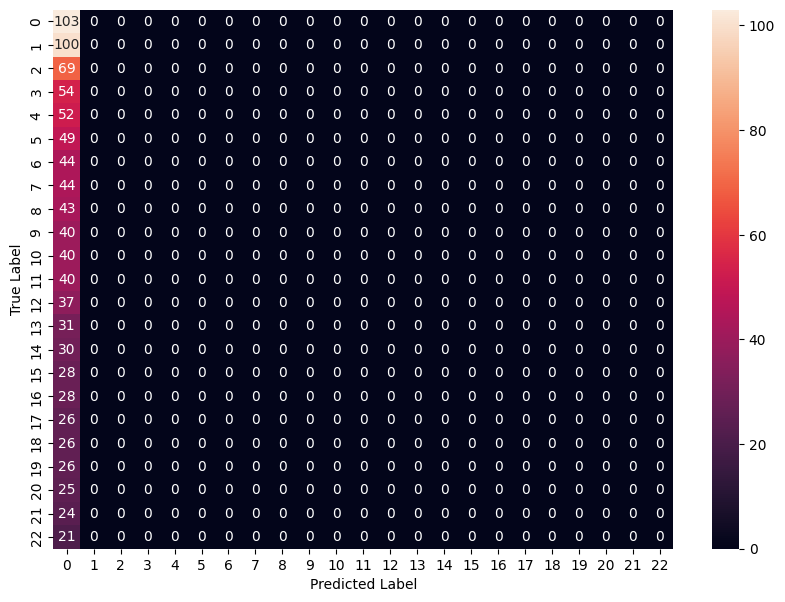

              precision    recall  f1-score   support

           0       0.11      1.00      0.19       103
           1       0.00      0.00      0.00       100
           2       0.00      0.00      0.00        69
           3       0.00      0.00      0.00        54
           4       0.00      0.00      0.00        52
           5       0.00      0.00      0.00        49
           6       0.00      0.00      0.00        44
           7       0.00      0.00      0.00        44
           8       0.00      0.00      0.00        43
           9       0.00      0.00      0.00        40
          10       0.00      0.00      0.00        40
          11       0.00      0.00      0.00        40
          12       0.00      0.00      0.00        37
          13       0.00      0.00      0.00        31
          14       0.00      0.00      0.00        30
          15       0.00      0.00      0.00        28
          16       0.00      0.00      0.00        28
          17       0.00    

/Users/ryan/Documents/GitHub/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ryan/Documents/GitHub/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ryan/Documents/GitHub/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

In [24]:
y_pred = pretrained_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Visualize confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Classification report
print(classification_report(y_test, y_pred_classes))

## External Dataset Result - Pretrained Model

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


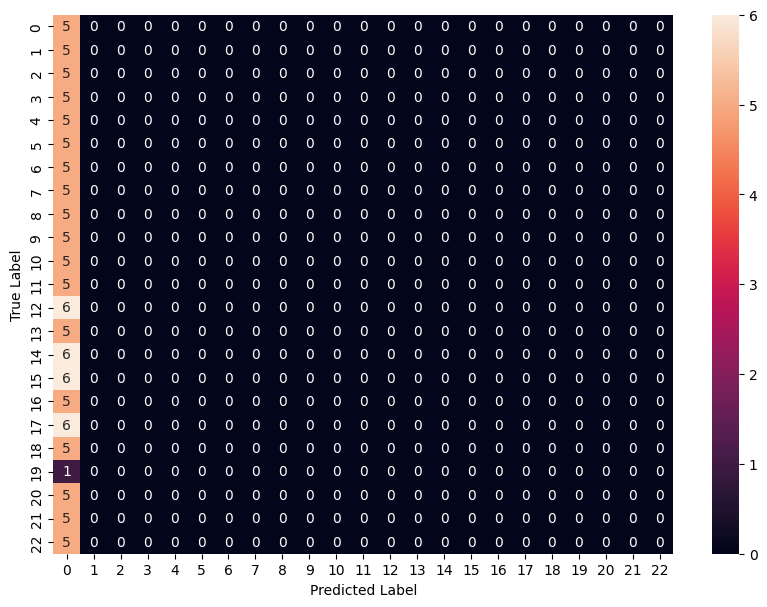

              precision    recall  f1-score   support

           0       0.04      1.00      0.08         5
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00         5
           7       0.00      0.00      0.00         5
           8       0.00      0.00      0.00         5
           9       0.00      0.00      0.00         5
          10       0.00      0.00      0.00         5
          11       0.00      0.00      0.00         5
          12       0.00      0.00      0.00         6
          13       0.00      0.00      0.00         5
          14       0.00      0.00      0.00         6
          15       0.00      0.00      0.00         6
          16       0.00      0.00      0.00         5
          17       0.00    

/Users/ryan/Documents/GitHub/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ryan/Documents/GitHub/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ryan/Documents/GitHub/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

In [25]:
# Predict the external set
y_pred = pretrained_model.predict(X_new)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion matrix
conf_matrix = confusion_matrix(y_new, y_pred_classes)

# Visualize confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Classification report
print(classification_report(y_new, y_pred_classes))

# Random Forest

## K Fold Validation - Baseline Random Forest

In [26]:
k = 5  # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Store results for evaluation
accuracies = []

# Compute class weights to handle class imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

# Iterate over each fold
for fold, (train_index, val_index) in enumerate(kf.split(X_train_flat)):
    print(f"\nTraining fold {fold + 1}/{k}...")
    
    # Split data into training and validation for this fold
    X_train_flat_fold, X_val_flat_fold = X_train_flat[train_index], X_train_flat[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    # Train the Random Forest model
    rf_model_kfold = RandomForestClassifier(n_estimators=100, class_weight=class_weights_dict, random_state=42)
    rf_model_kfold.fit(X_train_flat_fold, y_train_fold)
    
    # Validate the model
    y_val_pred = rf_model_kfold.predict(X_val_flat_fold)
    
    # Calculate accuracy for this fold
    accuracy = accuracy_score(y_val_fold, y_val_pred)
    accuracies.append(accuracy)

    # Print results for the current fold
    print(f"Fold {fold + 1} Accuracy: {accuracy}")
    
# Calculate and print the mean accuracy across all folds
mean_accuracy = np.mean(accuracies)
print(f"\nMean Accuracy after {k} folds: {mean_accuracy}")



Training fold 1/5...
Fold 1 Accuracy: 0.9475177304964539

Training fold 2/5...
Fold 2 Accuracy: 0.9546099290780142

Training fold 3/5...
Fold 3 Accuracy: 0.9390070921985816

Training fold 4/5...
Fold 4 Accuracy: 0.9659574468085106

Training fold 5/5...
Fold 5 Accuracy: 0.9573863636363636

Mean Accuracy after 5 folds: 0.9528957124435846


## Internal Dataset Result - Baseline Random Forest

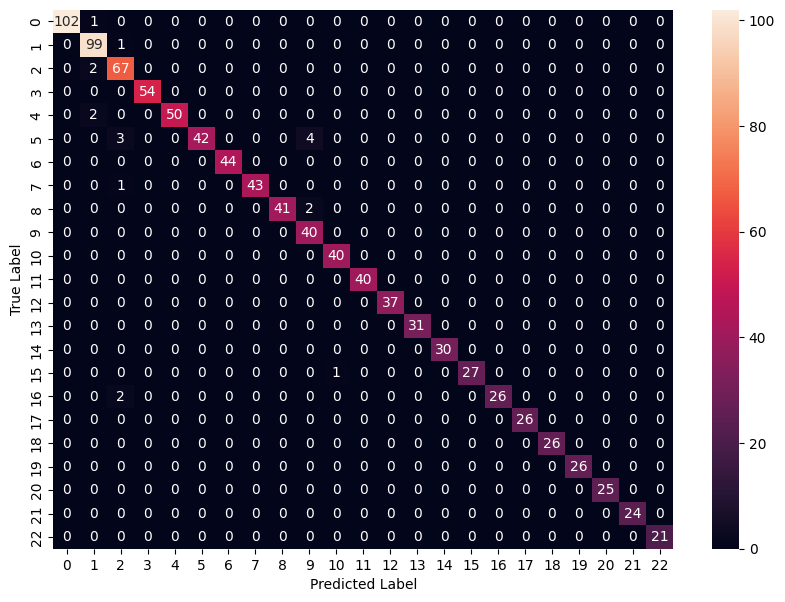

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       103
           1       0.95      0.99      0.97       100
           2       0.91      0.97      0.94        69
           3       1.00      1.00      1.00        54
           4       1.00      0.96      0.98        52
           5       1.00      0.86      0.92        49
           6       1.00      1.00      1.00        44
           7       1.00      0.98      0.99        44
           8       1.00      0.95      0.98        43
           9       0.87      1.00      0.93        40
          10       0.98      1.00      0.99        40
          11       1.00      1.00      1.00        40
          12       1.00      1.00      1.00        37
          13       1.00      1.00      1.00        31
          14       1.00      1.00      1.00        30
          15       1.00      0.96      0.98        28
          16       1.00      0.93      0.96        28
          17       1.00    

In [27]:
rf_model = RandomForestClassifier(n_estimators=100, class_weight=class_weights_dict, random_state=42)
rf_model.fit(X_train_flat, y_train)

# Make predictions on the new test set
y_pred = rf_model.predict(X_test_flat)

# Confusion matrix for the new dataset
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Classification report
print(classification_report(y_test, y_pred))

## External Dataset - Baseline Random Forest

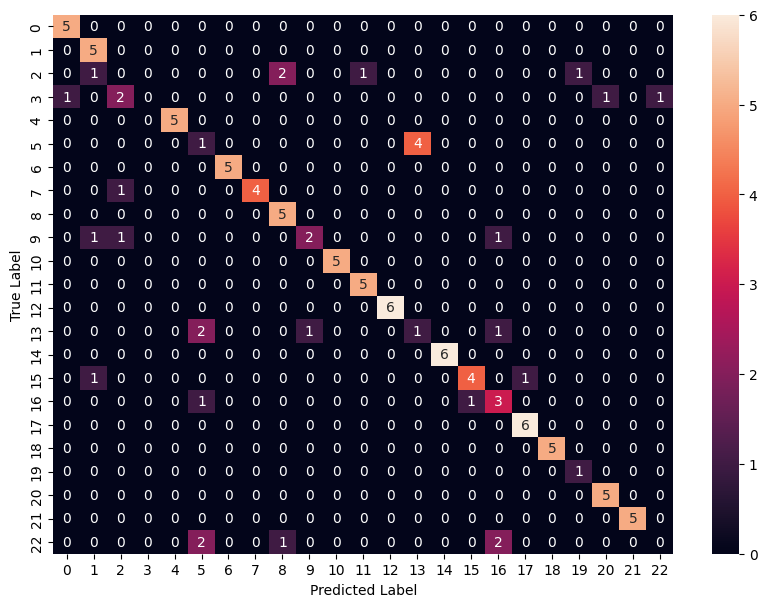

              precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       0.62      1.00      0.77         5
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         5
           4       1.00      1.00      1.00         5
           5       0.17      0.20      0.18         5
           6       1.00      1.00      1.00         5
           7       1.00      0.80      0.89         5
           8       0.62      1.00      0.77         5
           9       0.67      0.40      0.50         5
          10       1.00      1.00      1.00         5
          11       0.83      1.00      0.91         5
          12       1.00      1.00      1.00         6
          13       0.20      0.20      0.20         5
          14       1.00      1.00      1.00         6
          15       0.80      0.67      0.73         6
          16       0.43      0.60      0.50         5
          17       0.86    

/Users/ryan/Documents/GitHub/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ryan/Documents/GitHub/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ryan/Documents/GitHub/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

In [28]:
rf_model.fit(X_train_flat, y_train)
# Make predictions on the new test set
y_new_pred = rf_model.predict(X_new_flat)

# Confusion matrix for the new dataset
conf_matrix_new = confusion_matrix(y_new, y_new_pred)

# Visualize the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_new, annot=True, fmt="d")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Evaluate the model on the new dataset
print(classification_report(y_new, y_new_pred))

## Apply Pooling Layer - Random Forest

In [29]:
POOL_SIZE = 4
STRIDE = 2

def max_pooling(input_feature_map, pool_size, stride):
    input_height, input_width, input_channels = input_feature_map.shape

    #calculating how many steps the window can take vertically 
    output_height = (input_height - pool_size) // stride + 1

    #calculate how many steps the window can take horizontally 
    output_width = (input_width - pool_size) // stride + 1

    #Initalizing the output feature map with all zeros first
    output_feature_map = np.zeros((output_height, output_width, input_channels))

    for h in range(0, input_height - pool_size + 1, stride):
        for w in range(0, input_width - pool_size + 1, stride):
            for c in range(input_channels): 
                #extracting the current window in the image 
                window = input_feature_map[h:h + pool_size, w:w + pool_size, c]
                #computing the maximum value in each window 
                output_feature_map[h // stride, w // stride, c] = np.max(window)
    
    return output_feature_map

X_max_pooled = np.array([max_pooling(img, POOL_SIZE, STRIDE) for img in X])
X_pool_flatten = X_max_pooled.reshape(X_max_pooled.shape[0], -1)
X_train_pool, X_test_pool, y_train_pool, y_test_pool = train_test_split(X_pool_flatten, y, test_size=0.2, random_state=42)

## K-fold Validation - Pooled Random Forest

In [30]:
k = 5  # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Store results for evaluation
accuracies = []

# Compute class weights to handle class imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

# Iterate over each fold
for fold, (train_index, val_index) in enumerate(kf.split(X_train_flat)):
    print(f"\nTraining fold {fold + 1}/{k}...")
    
    # Split data into training and validation for this fold
    X_train_flat_fold, X_val_flat_fold = X_train_pool[train_index], X_train_pool[val_index]
    y_train_fold, y_val_fold = y_train_pool[train_index], y_train_pool[val_index]
    
    # Train the Random Forest model
    rf_model_kfold = RandomForestClassifier(n_estimators=100, class_weight=class_weights_dict, random_state=42)
    rf_model_kfold.fit(X_train_flat_fold, y_train_fold)
    
    # Validate the model
    y_val_pred = rf_model_kfold.predict(X_val_flat_fold)
    
    # Calculate accuracy for this fold
    accuracy = accuracy_score(y_val_fold, y_val_pred)
    accuracies.append(accuracy)
    
    # Print results for the current fold
    print(f"Fold {fold + 1} Accuracy: {accuracy}")
    
# Calculate and print the mean accuracy across all folds
mean_accuracy = np.mean(accuracies)
print(f"\nMean Accuracy after {k} folds: {mean_accuracy}")


Training fold 1/5...
Fold 1 Accuracy: 0.9290780141843972

Training fold 2/5...
Fold 2 Accuracy: 0.9219858156028369

Training fold 3/5...
Fold 3 Accuracy: 0.9219858156028369

Training fold 4/5...
Fold 4 Accuracy: 0.926241134751773

Training fold 5/5...
Fold 5 Accuracy: 0.9232954545454546

Mean Accuracy after 5 folds: 0.9245172469374596


## Internal Dataset Result - Pooled Random Forest

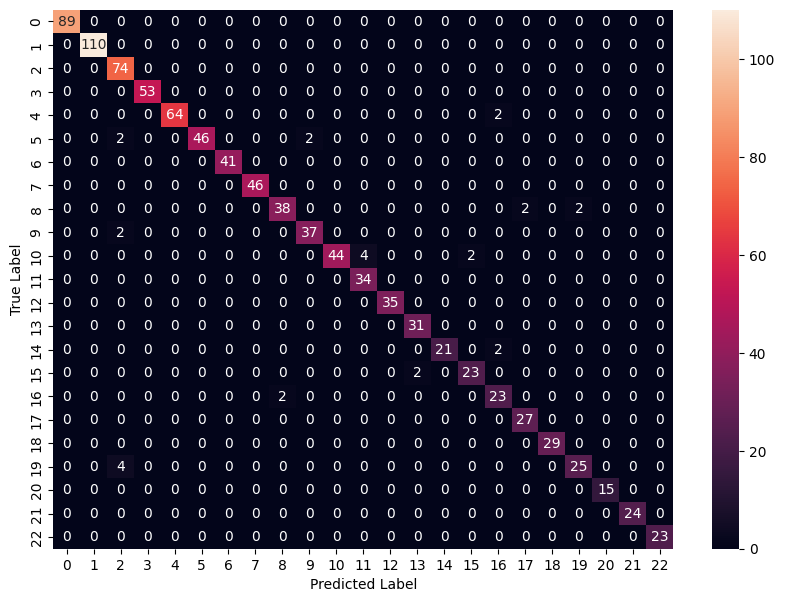

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        89
           1       1.00      1.00      1.00       110
           2       0.90      1.00      0.95        74
           3       1.00      1.00      1.00        53
           4       1.00      0.97      0.98        66
           5       1.00      0.92      0.96        50
           6       1.00      1.00      1.00        41
           7       1.00      1.00      1.00        46
           8       0.95      0.90      0.93        42
           9       0.95      0.95      0.95        39
          10       1.00      0.88      0.94        50
          11       0.89      1.00      0.94        34
          12       1.00      1.00      1.00        35
          13       0.94      1.00      0.97        31
          14       1.00      0.91      0.95        23
          15       0.92      0.92      0.92        25
          16       0.85      0.92      0.88        25
          17       0.93    

In [31]:
# Internal Test Set

rf_model = RandomForestClassifier(n_estimators=100, class_weight=class_weights_dict, random_state=42)

# Make predictions on the internal test set
rf_model.fit(X_train_pool, y_train_pool)
y_pred = rf_model.predict(X_test_pool)

# Confusion matrix for the new dataset
conf_matrix = confusion_matrix(y_test_pool, y_pred)

# Visualize the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Classification report
print(classification_report(y_test_pool, y_pred))

## External Dataset Result - Pooled Random Forest

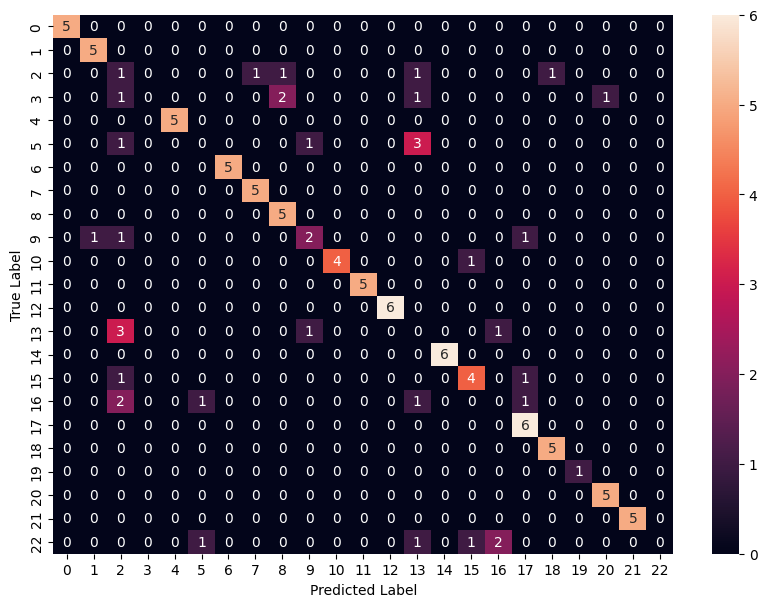

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.83      1.00      0.91         5
           2       0.10      0.20      0.13         5
           3       0.00      0.00      0.00         5
           4       1.00      1.00      1.00         5
           5       0.00      0.00      0.00         5
           6       1.00      1.00      1.00         5
           7       0.83      1.00      0.91         5
           8       0.62      1.00      0.77         5
           9       0.50      0.40      0.44         5
          10       1.00      0.80      0.89         5
          11       1.00      1.00      1.00         5
          12       1.00      1.00      1.00         6
          13       0.00      0.00      0.00         5
          14       1.00      1.00      1.00         6
          15       0.67      0.67      0.67         6
          16       0.00      0.00      0.00         5
          17       0.67    

/Users/ryan/Documents/GitHub/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ryan/Documents/GitHub/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ryan/Documents/GitHub/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

In [32]:
X_new_pooled = np.array([max_pooling(img, POOL_SIZE, STRIDE) for img in X_new])
X_pool_flatten = X_new_pooled.reshape(X_new_pooled.shape[0], -1)

# Make predictions on the external test set
rf_model.fit(X_train_pool, y_train_pool)
y_new_pred = rf_model.predict(X_pool_flatten)

# Confusion matrix for the external dataset
conf_matrix_new = confusion_matrix(y_new, y_new_pred)

# Visualize the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_new, annot=True, fmt="d")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Classification report
print(classification_report(y_new, y_new_pred))

# KNN

## K-fold Validation - Baseline KNN

In [33]:
k = 5  # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Store results for evaluation
accuracies = []

# Iterate over each fold
for fold, (train_index, val_index) in enumerate(kf.split(X_train_flat)):
    print(f"\nTraining fold {fold + 1}/{k}...")
    
    # Split data into training and validation for this fold
    X_train_flat_fold, X_val_flat_fold = X_train_flat[train_index], X_train_flat[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    # Train the Random Forest model
    knn_fold = KNeighborsClassifier(n_neighbors=5)
    knn_fold.fit(X_train_flat_fold, y_train_fold)
    
    # Validate the model
    y_val_pred = knn_fold.predict(X_val_flat_fold)
    
    # Calculate accuracy for this fold
    accuracy = accuracy_score(y_val_fold, y_val_pred)
    accuracies.append(accuracy)

    # Print results for the current fold
    print(f"Fold {fold + 1} Accuracy: {accuracy}")
    
# Calculate and print the mean accuracy across all folds
mean_accuracy = np.mean(accuracies)
print(f"\nMean Accuracy after {k} folds: {mean_accuracy}")


Training fold 1/5...
Fold 1 Accuracy: 0.7205673758865249

Training fold 2/5...
Fold 2 Accuracy: 0.7063829787234043

Training fold 3/5...
Fold 3 Accuracy: 0.7205673758865249

Training fold 4/5...
Fold 4 Accuracy: 0.7475177304964539

Training fold 5/5...
Fold 5 Accuracy: 0.7088068181818182

Mean Accuracy after 5 folds: 0.7207684558349452


## Internal Dataset Result - Baseline KNN

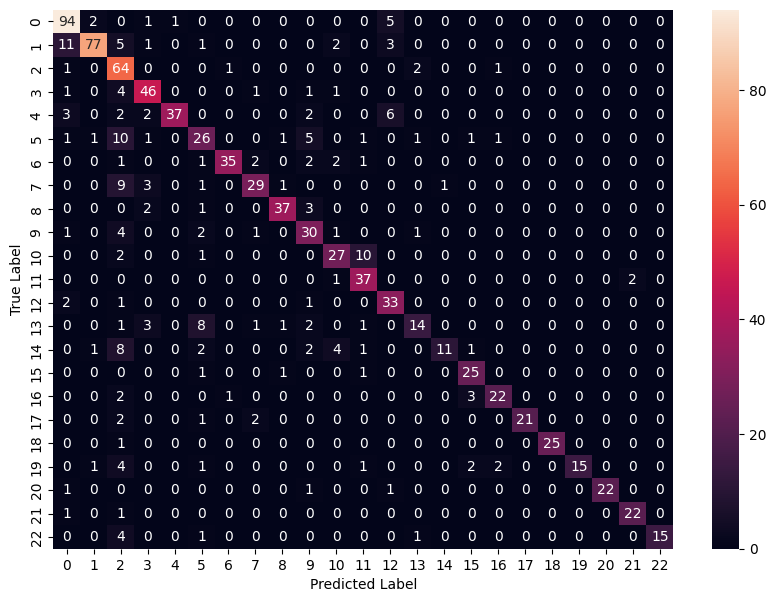

              precision    recall  f1-score   support

           0       0.81      0.91      0.86       103
           1       0.94      0.77      0.85       100
           2       0.51      0.93      0.66        69
           3       0.78      0.85      0.81        54
           4       0.97      0.71      0.82        52
           5       0.55      0.53      0.54        49
           6       0.95      0.80      0.86        44
           7       0.81      0.66      0.72        44
           8       0.90      0.86      0.88        43
           9       0.61      0.75      0.67        40
          10       0.71      0.68      0.69        40
          11       0.70      0.93      0.80        40
          12       0.69      0.89      0.78        37
          13       0.74      0.45      0.56        31
          14       0.92      0.37      0.52        30
          15       0.78      0.89      0.83        28
          16       0.85      0.79      0.81        28
          17       1.00    

In [34]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_flat, y_train)

# Predict on validation and test set
y_pred = knn.predict(X_test_flat)

# Confusion matrix for the new dataset
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Classification report
print(classification_report(y_test, y_pred))

## External Dataset Result - Baseline KNN

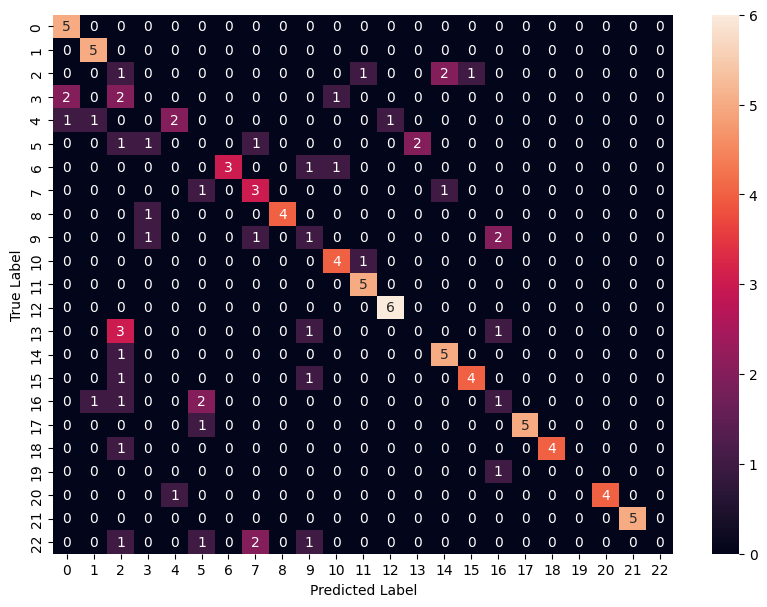

              precision    recall  f1-score   support

           0       0.62      1.00      0.77         5
           1       0.71      1.00      0.83         5
           2       0.08      0.20      0.12         5
           3       0.00      0.00      0.00         5
           4       0.67      0.40      0.50         5
           5       0.00      0.00      0.00         5
           6       1.00      0.60      0.75         5
           7       0.43      0.60      0.50         5
           8       1.00      0.80      0.89         5
           9       0.20      0.20      0.20         5
          10       0.67      0.80      0.73         5
          11       0.71      1.00      0.83         5
          12       0.86      1.00      0.92         6
          13       0.00      0.00      0.00         5
          14       0.62      0.83      0.71         6
          15       0.80      0.67      0.73         6
          16       0.20      0.20      0.20         5
          17       1.00    

/Users/ryan/Documents/GitHub/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ryan/Documents/GitHub/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ryan/Documents/GitHub/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

In [35]:
# Flatten the new dataset
X_new_flat = X_new.reshape(X_new.shape[0], -1)

# Make predictions on the new test set
y_new_pred = knn.predict(X_new_flat)

# Confusion matrix for the new dataset
conf_matrix_new = confusion_matrix(y_new, y_new_pred)

# Visualize the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_new, annot=True, fmt="d")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Evaluate the model on the new dataset
print(classification_report(y_new, y_new_pred))

## Applying Pooling layer on KNN

In [36]:
k = 5  # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Store results for evaluation
accuracies = []

# Iterate over each fold
for fold, (train_index, val_index) in enumerate(kf.split(X_train_pool)):
    print(f"\nTraining fold {fold + 1}/{k}...")
    
    # Split data into training and validation for this fold
    X_train_flat_fold, X_val_flat_fold = X_train_pool[train_index], X_train_pool[val_index]
    y_train_fold, y_val_fold = y_train_pool[train_index], y_train_pool[val_index]
    
    # Train KNN
    knn_fold = KNeighborsClassifier(n_neighbors=5)
    knn_fold.fit(X_train_flat_fold, y_train_fold)
    
    # Validate the model
    y_val_pred = knn_fold.predict(X_val_flat_fold)
    
    # Calculate accuracy for this fold
    accuracy = accuracy_score(y_val_fold, y_val_pred)
    accuracies.append(accuracy)
    
    # Print results for the current fold
    print(f"Fold {fold + 1} Accuracy: {accuracy}")
    
# Calculate and print the mean accuracy across all folds
mean_accuracy = np.mean(accuracies)
print(f"\nMean Accuracy after {k} folds: {mean_accuracy}")


Training fold 1/5...
Fold 1 Accuracy: 0.7410714285714286

Training fold 2/5...
Fold 2 Accuracy: 0.6909323116219668

Training fold 3/5...
Fold 3 Accuracy: 0.6666666666666666

Training fold 4/5...
Fold 4 Accuracy: 0.7011494252873564

Training fold 5/5...
Fold 5 Accuracy: 0.7177522349936143

Mean Accuracy after 5 folds: 0.7035144134282065


## Internal Dataset Result - Pooled KNN

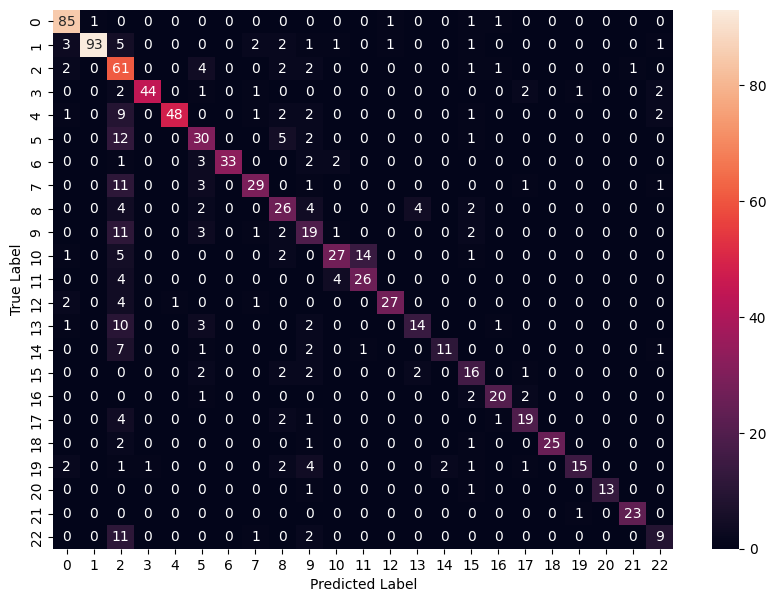

              precision    recall  f1-score   support

           0       0.88      0.96      0.91        89
           1       0.99      0.85      0.91       110
           2       0.37      0.82      0.51        74
           3       0.98      0.83      0.90        53
           4       0.98      0.73      0.83        66
           5       0.57      0.60      0.58        50
           6       1.00      0.80      0.89        41
           7       0.81      0.63      0.71        46
           8       0.55      0.62      0.58        42
           9       0.40      0.49      0.44        39
          10       0.77      0.54      0.64        50
          11       0.63      0.76      0.69        34
          12       0.93      0.77      0.84        35
          13       0.70      0.45      0.55        31
          14       0.85      0.48      0.61        23
          15       0.52      0.64      0.57        25
          16       0.83      0.80      0.82        25
          17       0.73    

In [37]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_pool, y_train_pool)

# Predict on validation and test set
y_pred = knn.predict(X_test_pool)

# Confusion matrix for the new dataset
conf_matrix = confusion_matrix(y_test_pool, y_pred)

# Visualize the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Classification report
print(classification_report(y_test_pool, y_pred))

## External Dataset Result - Pooled KNN

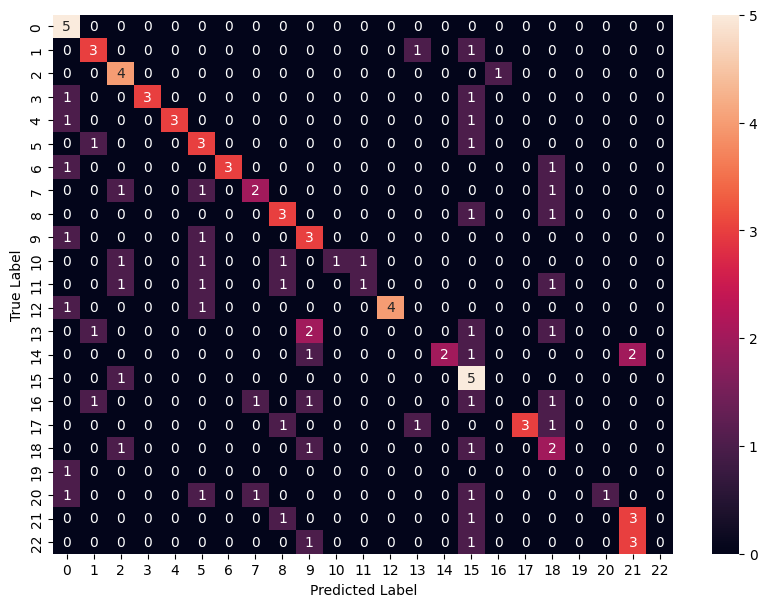

              precision    recall  f1-score   support

           0       0.42      1.00      0.59         5
           1       0.50      0.60      0.55         5
           2       0.44      0.80      0.57         5
           3       1.00      0.60      0.75         5
           4       1.00      0.60      0.75         5
           5       0.33      0.60      0.43         5
           6       1.00      0.60      0.75         5
           7       0.50      0.40      0.44         5
           8       0.43      0.60      0.50         5
           9       0.33      0.60      0.43         5
          10       1.00      0.20      0.33         5
          11       0.50      0.20      0.29         5
          12       1.00      0.67      0.80         6
          13       0.00      0.00      0.00         5
          14       1.00      0.33      0.50         6
          15       0.29      0.83      0.43         6
          16       0.00      0.00      0.00         5
          17       1.00    

/Users/ryan/Documents/GitHub/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ryan/Documents/GitHub/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ryan/Documents/GitHub/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

In [38]:
X_new_pooled = np.array([max_pooling(img, POOL_SIZE, STRIDE) for img in X_new])
X_pool_flatten = X_new_pooled.reshape(X_new_pooled.shape[0], -1)

knn.fit(X_pool_flatten, y_new)
# Make predictions on the new test set
y_new_pred = knn.predict(X_pool_flatten)

# Confusion matrix for the new dataset
conf_matrix_new = confusion_matrix(y_new, y_new_pred)

# Visualize the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_new, annot=True, fmt="d")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Evaluate the model on the new dataset
print(classification_report(y_new, y_new_pred))

# SVM

## Internal Datset Result - Baseline SVM

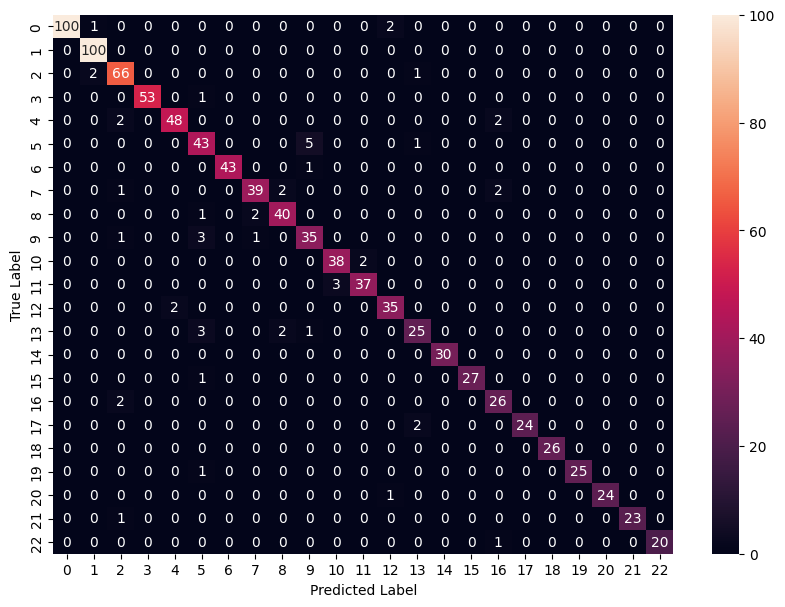

Accuracy: 0.9459183673469388
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99       103
           1       0.97      1.00      0.99       100
           2       0.90      0.96      0.93        69
           3       1.00      0.98      0.99        54
           4       0.96      0.92      0.94        52
           5       0.81      0.88      0.84        49
           6       1.00      0.98      0.99        44
           7       0.93      0.89      0.91        44
           8       0.91      0.93      0.92        43
           9       0.83      0.88      0.85        40
          10       0.93      0.95      0.94        40
          11       0.95      0.93      0.94        40
          12       0.92      0.95      0.93        37
          13       0.86      0.81      0.83        31
          14       1.00      1.00      1.00        30
          15       1.00      0.96      0.98        28
          16       0.84     

In [39]:
#standardize the features 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_flat)
X_test = scaler.transform(X_test_flat)

#Train the SVM model with the training set
svm_model = SVC(kernel='rbf', gamma='scale', C=1.0)
svm_model.fit(X_train, y_train)

# Predict on the test set
y_pred = svm_model.predict(X_test)

# Confusion matrix for the new dataset
conf_matrix_new = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_new, annot=True, fmt="d")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

## External Datset Result - Baseline SVM

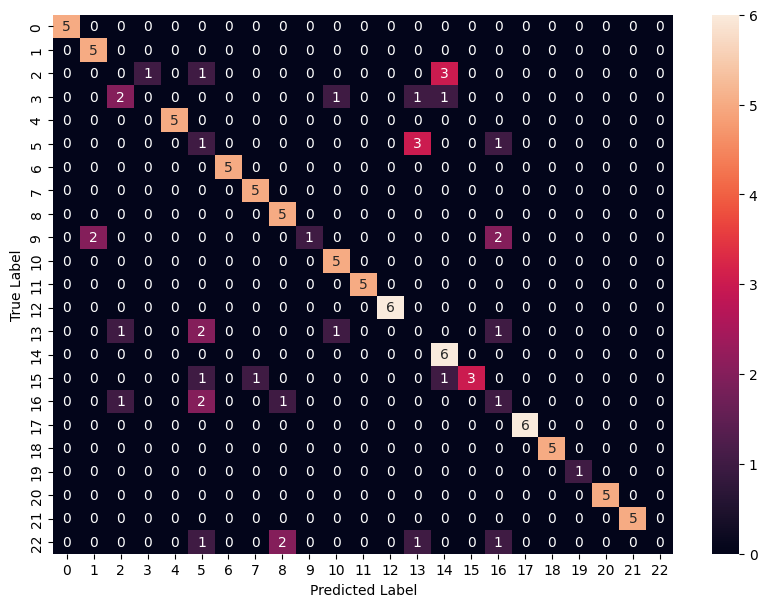

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.71      1.00      0.83         5
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         5
           4       1.00      1.00      1.00         5
           5       0.12      0.20      0.15         5
           6       1.00      1.00      1.00         5
           7       0.83      1.00      0.91         5
           8       0.62      1.00      0.77         5
           9       1.00      0.20      0.33         5
          10       0.71      1.00      0.83         5
          11       1.00      1.00      1.00         5
          12       1.00      1.00      1.00         6
          13       0.00      0.00      0.00         5
          14       0.55      1.00      0.71         6
          15       1.00      0.50      0.67         6
          16       0.17      0.20      0.18         5
          17       1.00    

/Users/ryan/Documents/GitHub/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ryan/Documents/GitHub/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ryan/Documents/GitHub/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

In [40]:
# Flatten the new dataset
X_new_flat = X_new.reshape(X_new.shape[0], -1)
X_new_flat = scaler.transform(X_new_flat)

# Make predictions on the new test set
y_new_pred = svm_model.predict(X_new_flat)

# Confusion matrix for the new dataset
conf_matrix_new = confusion_matrix(y_new, y_new_pred)

# Visualize the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_new, annot=True, fmt="d")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Evaluate the model on the new dataset
print(classification_report(y_new, y_new_pred))

## Internal Datset Result - Pooled SVM

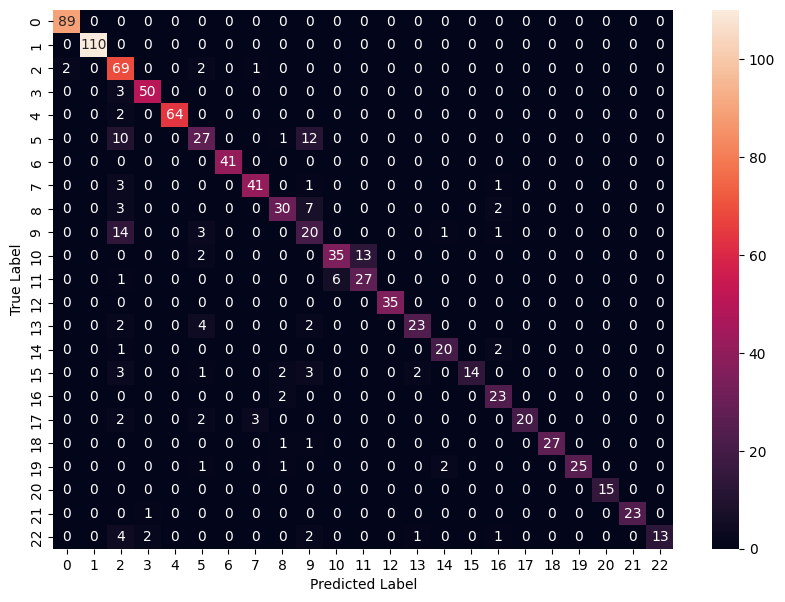

Accuracy: 0.8581632653061224
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99        89
           1       1.00      1.00      1.00       110
           2       0.59      0.93      0.72        74
           3       0.94      0.94      0.94        53
           4       1.00      0.97      0.98        66
           5       0.64      0.54      0.59        50
           6       1.00      1.00      1.00        41
           7       0.91      0.89      0.90        46
           8       0.81      0.71      0.76        42
           9       0.42      0.51      0.46        39
          10       0.85      0.70      0.77        50
          11       0.68      0.79      0.73        34
          12       1.00      1.00      1.00        35
          13       0.88      0.74      0.81        31
          14       0.87      0.87      0.87        23
          15       1.00      0.56      0.72        25
          16       0.77     

In [41]:
#standardize the features 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_pool)
X_test = scaler.transform(X_test_pool)

#Train the SVM model with the training set
svm_model_pool = SVC(kernel='rbf', gamma='scale', C=1.0)
svm_model_pool.fit(X_train, y_train_pool)

# Predict on the test set
y_pred = svm_model_pool.predict(X_test)

# Confusion matrix and evaluation
conf_matrix_new = confusion_matrix(y_test_pool, y_pred)

# Visualize the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_new, annot=True, fmt="d")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print("Accuracy:", accuracy_score(y_test_pool, y_pred))
print("Classification Report:\n", classification_report(y_test_pool, y_pred))

## External Datset Result - Pooled SVM

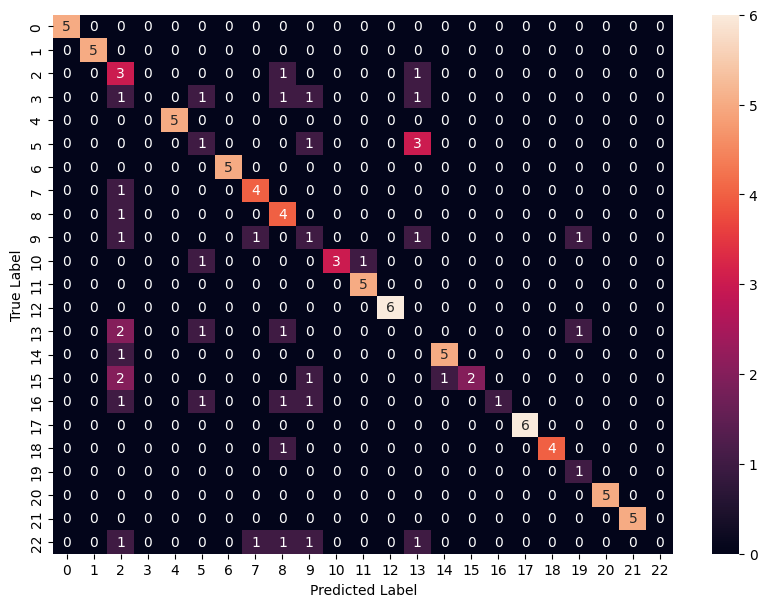

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       0.21      0.60      0.32         5
           3       0.00      0.00      0.00         5
           4       1.00      1.00      1.00         5
           5       0.20      0.20      0.20         5
           6       1.00      1.00      1.00         5
           7       0.67      0.80      0.73         5
           8       0.40      0.80      0.53         5
           9       0.17      0.20      0.18         5
          10       1.00      0.60      0.75         5
          11       0.83      1.00      0.91         5
          12       1.00      1.00      1.00         6
          13       0.00      0.00      0.00         5
          14       0.83      0.83      0.83         6
          15       1.00      0.33      0.50         6
          16       1.00      0.20      0.33         5
          17       1.00    

/Users/ryan/Documents/GitHub/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ryan/Documents/GitHub/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ryan/Documents/GitHub/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

In [42]:
X_max_pooled = np.array([max_pooling(img, POOL_SIZE, STRIDE) for img in X_new])
X_new_flat = X_max_pooled.reshape(X_max_pooled.shape[0], -1)

# Option 1: Refit the scaler if the new data shape is different
scaler.fit(X_new_flat)

# Scale the new flattened data
X_new_flat_scaled = scaler.transform(X_new_flat)

# Make predictions on the scaled new test set
y_new_pred = svm_model_pool.predict(X_new_flat_scaled)

# Confusion matrix and evaluation
conf_matrix_new = confusion_matrix(y_new, y_new_pred)

# Visualize the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_new, annot=True, fmt="d")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Evaluate the model on the new dataset
print(classification_report(y_new, y_new_pred))